Executive Summary:
---
The motivation for this project is to incorporate Bayesian Perspective in modeling real world problems. Most of the linear models are used by assuming that our data follows a normal distribution and then we can use the Linear Regression to measure the relationship between certain variables. I had heard the term Poisson Regression and applied it on the count data by staright up taking the log of the Outcome variable because Exp() works as a link function in Poisson Regression. Usually when we apply Linear Regression what we do is that we think our response variable follows a Normal Distribution. But as explained here we can incorporate the idea of Generalized Linear Model by thinking that our response variable follows a Poisson Distribution as it would help us model the Counts data. Also, we all had learnt the term "Lasso Regression" during our basic Machine Learning courses where we know the penalty in lasso put most of the coefficient variables to zero, giving us the most important variables. So, i would also like to implement Lasso Regression by putting a Laplace Prior on the coefficients for Dependent Variables.
So, the idea here is, that as we are putting a relatively strict prior of Laplace Distribution on the coefficients (As Laplace is a distribution peaked at 0, which means that most of the observations lie around zero. So, after the modeling we would look at the Posterior Distribution of the Coefficients of Dependent Variables and see which of them have a Posterior away from zero and which have remained at zero. As, through this we can figure out the important variables for Regression.

Dataset:
---
I have used the data of daily bicycle counts in NYC bridge area for 10 months. The data was downloaded online. And the Precipitation, Max Temp and Min Temp of the day are given along with the date and Count.

Analysis Language:
---
All the analysis was performed in R programming language. I used Jupyter Notebooks as i can report metrics easily here. The important Libraries have been loaded in the next step to help with our analysis and modeling. I have used JAGS implementation in R through "rjags" library to implement JAGS algorithm for MCMC.

In [2]:
options(warnings=-1)
library(rjags)
library(coda)
library(bayesplot)
library(ggplot2)
library(stats)
library(tidyverse)
library(ggpubr)
library(lubridate)
library(gridExtra)
library(reshape2)

In [3]:
setwd('C:/Users/Muhammad Hussain/Desktop/MCMC Project')

Data Loading:
---

In [4]:
dataset=read_csv('nyc_bb_bicyclist_counts.csv')

Parsed with column specification:
cols(
  Date = col_character(),
  HIGH_T = col_double(),
  LOW_T = col_double(),
  PRECIP = col_double(),
  BB_COUNT = col_double()
)



Data Manipulation and Feature Engineering:
---
Some Data Manipulation, where i converted the Date into an appropriate format and created a few new features.
The Featires engineered are:
1. Day of Week - Specifying the day if week
2. Week End-Day - Using the Day of Week Variable previously created, i created this categorical variable that would give us the indication if the corresponding day is Weekend or a Weekday. It would help us uncover trends. As, sometime people tend to use bikes for commute more on weekdays as compared to weekends.
3. Month of year
4. Avg Temp - Average Temperature of the day by finding the mid point of Max and Min Temperature.
5. Temp Volatility - A variable that measures how volatile temperature was for that day. It's the difference between High Temperature and Low Temperature for each day.

In [5]:
dataset$Date=as.Date(dataset$Date,format='%d-%b-%y')
dataset=dataset %>% mutate(day_of_week=weekdays(Date),month=month(Date),avg_temp=(HIGH_T+LOW_T)/2,
                          temp_volatility=HIGH_T-LOW_T) %>% 
mutate(week_day_end=ifelse(day_of_week %in% c('Saturday','Sunday'),'Weekend','Weekday'))

In [6]:
head(dataset)

Date,HIGH_T,LOW_T,PRECIP,BB_COUNT,day_of_week,month,avg_temp,temp_volatility,week_day_end
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
2017-04-01,46.0,37,0.00,606,Saturday,4,41.50,9.0,Weekend
2017-04-02,62.1,41,0.00,2021,Sunday,4,51.55,21.1,Weekend
2017-04-03,63.0,50,0.03,2470,Monday,4,56.50,13.0,Weekday
2017-04-04,51.1,46,1.18,723,Tuesday,4,48.55,5.1,Weekday
2017-04-05,63.0,46,0.00,2807,Wednesday,4,54.50,17.0,Weekday
2017-04-06,48.9,41,0.73,461,Thursday,4,44.95,7.9,Weekday


In [7]:
colnames(dataset)[1:5] <- c("date","high_temp","low_temp","precip",'counts')

EDA (Exploratory Data Analysis):
---

As i had an intuition that maybe bicycle use is influenced by whether the day is Weekend or a Weekday. Let's see how the Number of Bikes on the bridge area differs w.r.t different months categorized by Weekdays and Weekends.

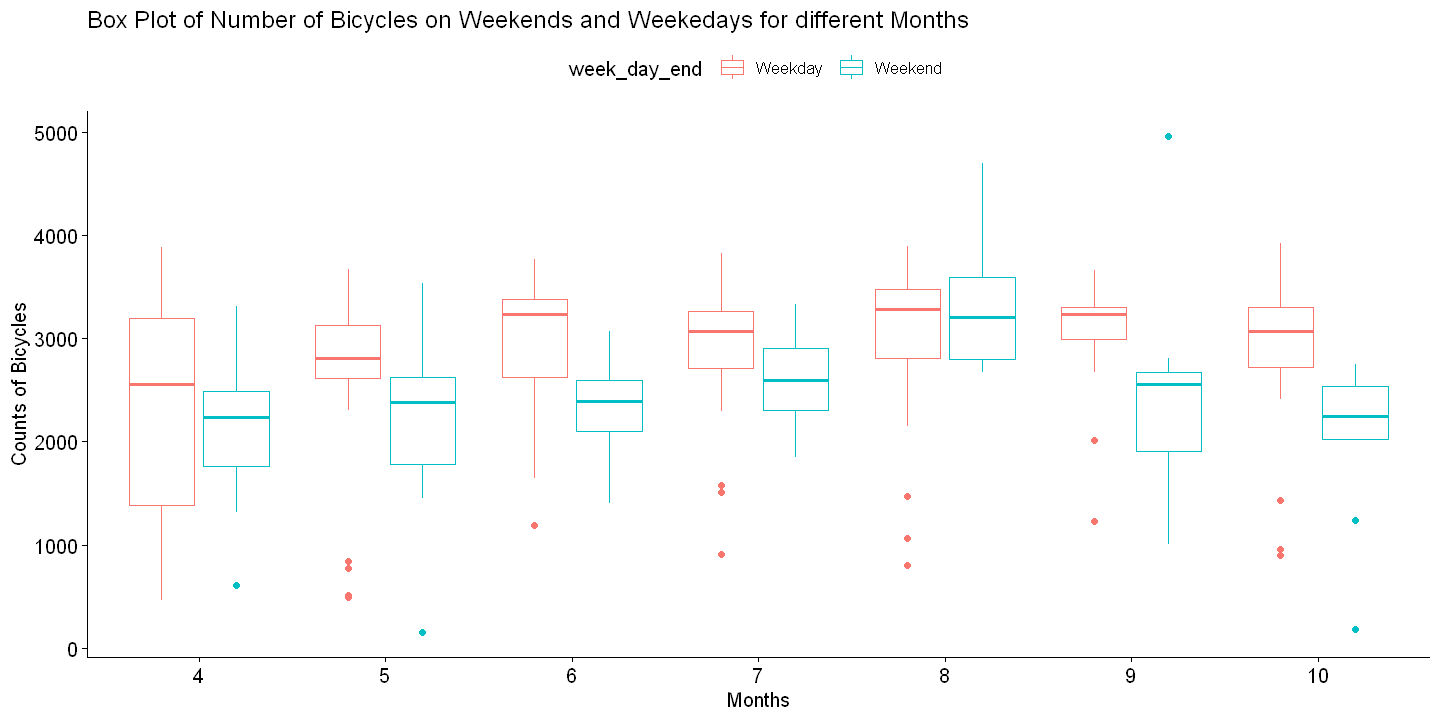

In [56]:
options(repr.plot.width=12, repr.plot.height=6)
ggboxplot(data=dataset,y='counts',x='month',col='week_day_end')+
labs(x='Months',y='Counts of Bicycles',title='Box Plot of Number of Bicycles on Weekends and Weekedays for different Months')

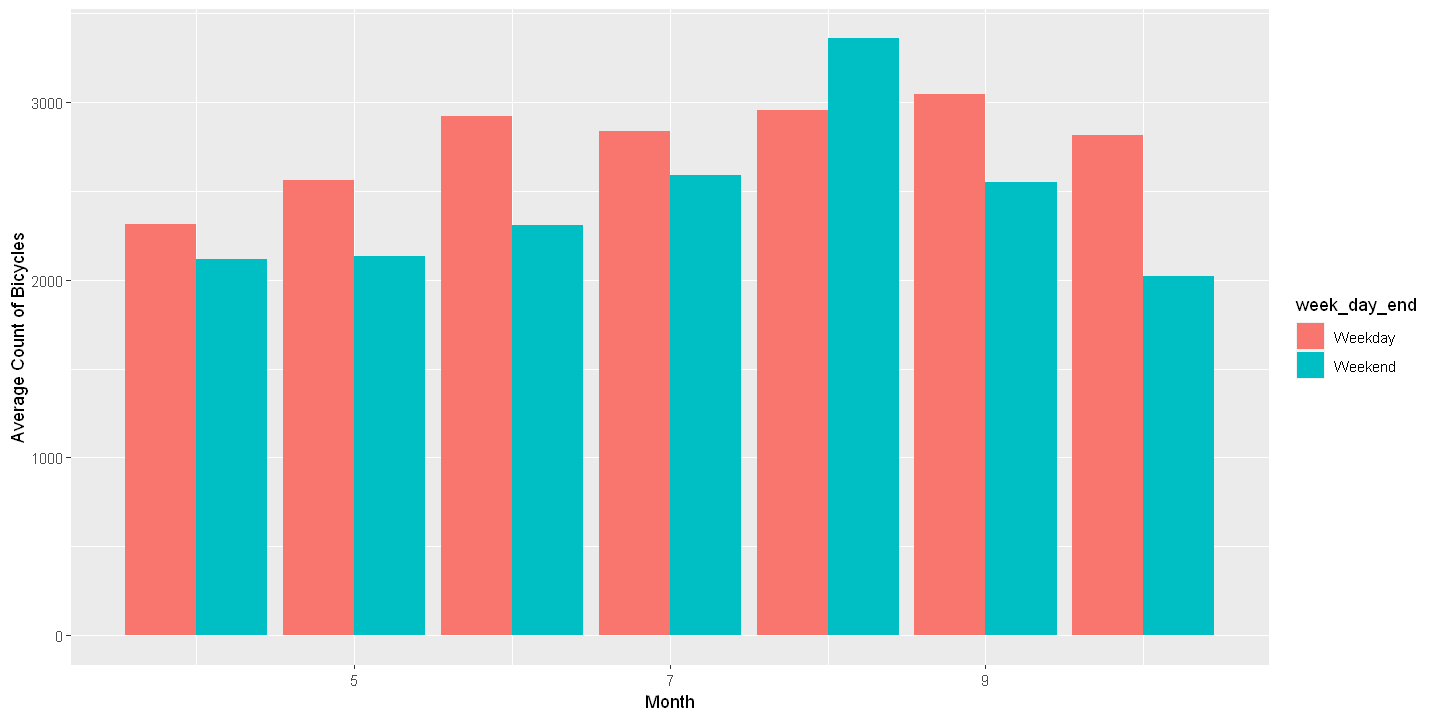

In [62]:
ggplot(dataset %>% group_by(month,week_day_end) %>%
      summarize(avg_counts=mean(counts)))+
geom_bar(aes(x=month,y=avg_counts,fill=week_day_end),position="dodge", stat="identity")+
labs(x='Month',y="Average Count of Bicycles")

So, after this short analysis i have 3 findings.
1. It seems like during the summer months the average number of bicycles spikes and then starts declining. As we approach the summers, there are more people who tend to go out and use the Bicycles and as we approach winter months the trend of Bicycle use decreases.
2. It is evident from the analysis that the Bicycle count is effected by the Day being "Weekday or Weekend". Thus, it seems to me that this newly created variable would have been an Exogenous variable, thus, i would incorporate it in my model to predict the Counts of Bicycles. 
3. For the month of August the Cycle count on weekend is higher than Weekdays, maybe it might be due to more tourism in the month of August.

Now, Let's analyze the temperature and precipitation over months and their correlation with the counts of bicycles.

Distribution of Avg Temperature and Temperature Volatility w.r.t different Months:
---

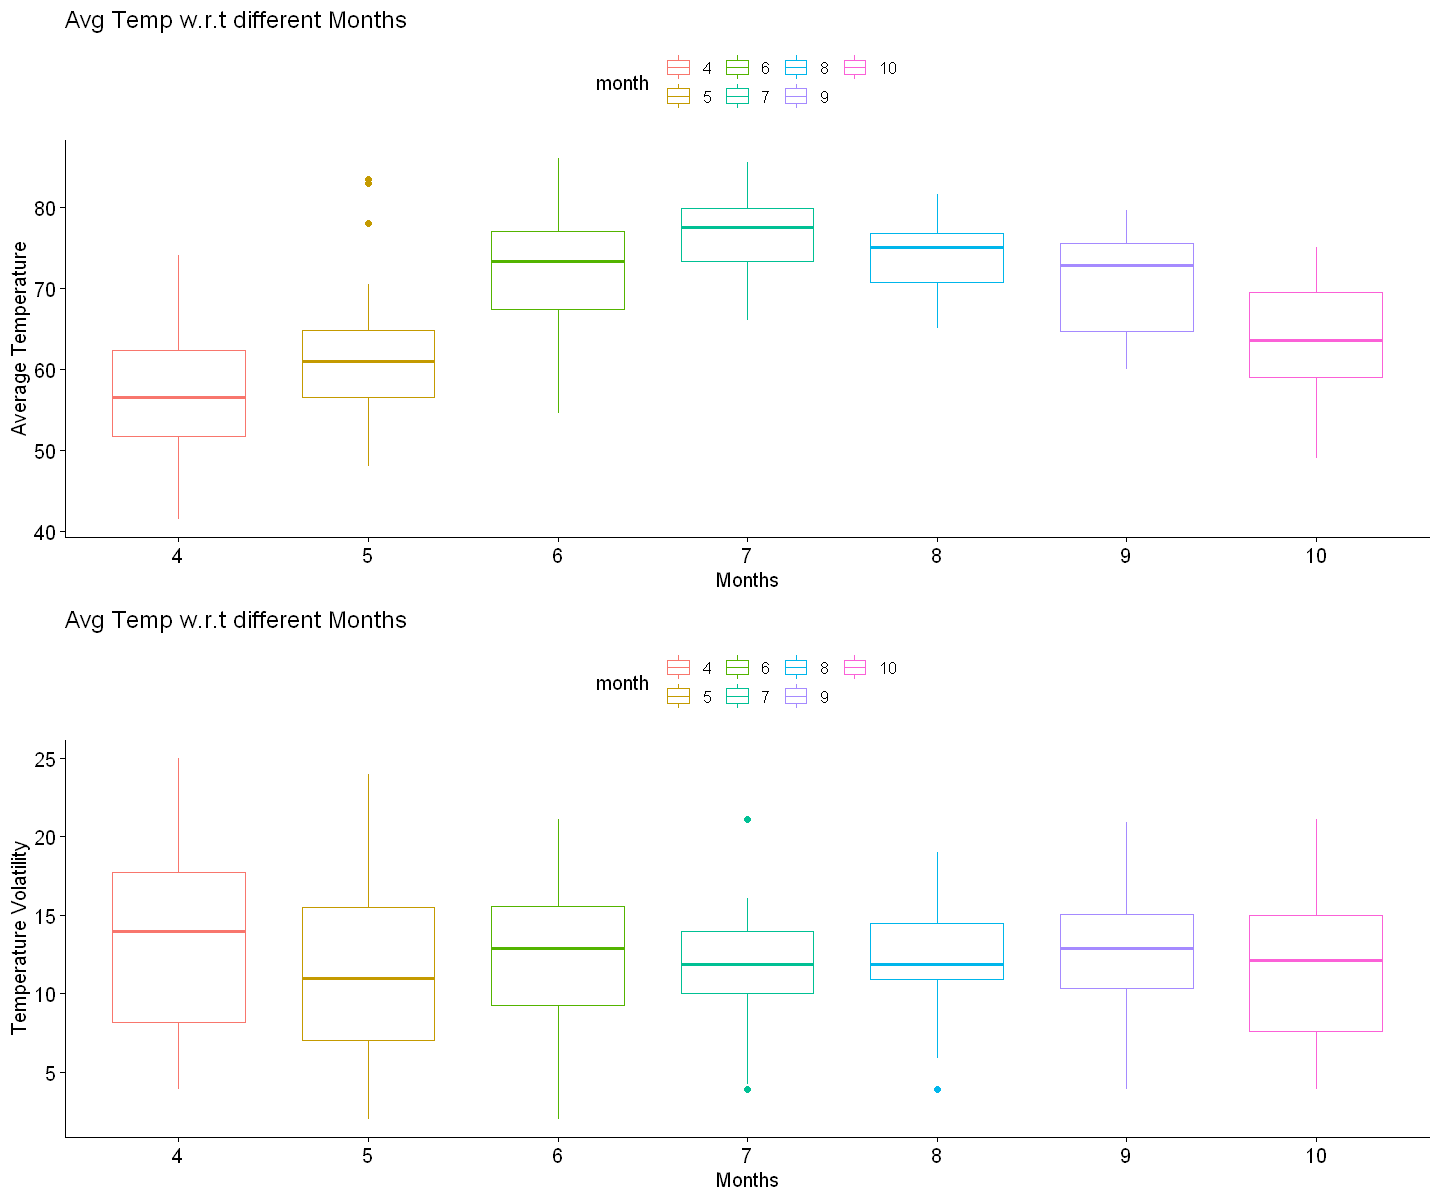

In [17]:
options(repr.plot.width=12, repr.plot.height=10)
g1=ggboxplot(data=dataset, x='month', y='avg_temp', col='month')+labs(title='Avg Temp w.r.t different Months', y='Average Temperature',
                                                      x='Months')
g2=ggboxplot(data=dataset, x='month', y='temp_volatility',col='month')+labs(title='Avg Temp w.r.t different Months', y='Temperature Volatility',
                                                      x='Months')

grid.arrange(g1,g2,ncol=1)



- Seems like the Average Temperature is different through different months and increases in summer months of June, July and August. And these are the months where the most bicycles count is observed. Hence there should be a positve correlation between the counts of bicycles and the temperature.
- The Temperature Volatility remains pretty much constant throughout the months. Indicating that this variable won't be of much importance in predicting the counts of bicycles.

Let's see the distribution of precipitation over different months.

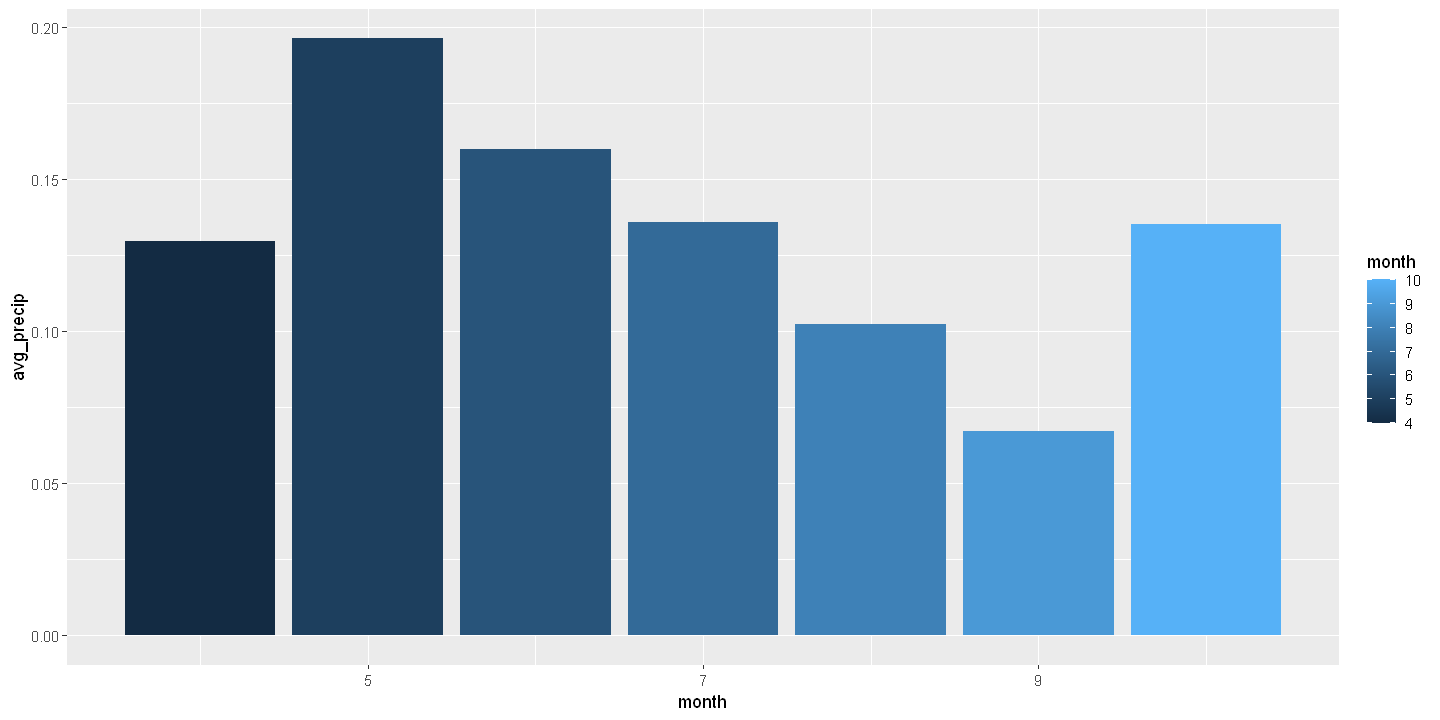

In [23]:
options(repr.plot.width=12, repr.plot.height=6)

# ggboxplot(dataset %>% group_by(month,day_of_week) %>% 
#           filter((precip > quantile(precip,0.25)-1.5*(IQR(precip))) | (precip < quantile(precip,0.75)+1.5*(IQR(precip)))), 
#                  x='month',y='precip',col='month')+ labs(title='Precipitation w.r.t months', x='Months',
#                                                           y='Precipitation')


ggplot(dataset %>% group_by(month) %>% summarize(avg_precip=mean(precip)))+
geom_bar(aes(x=month,y=avg_precip,fill=month),position="dodge", stat="identity")





The precipitation is lowest during the summers as it reduces with approching summer months and then starts increasing. Which shows that there is a negative correlation between precipitation and bicycle count.

Now, let's check the correlation between the avg. temperature, precipitation and the Counts of Bicycles.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



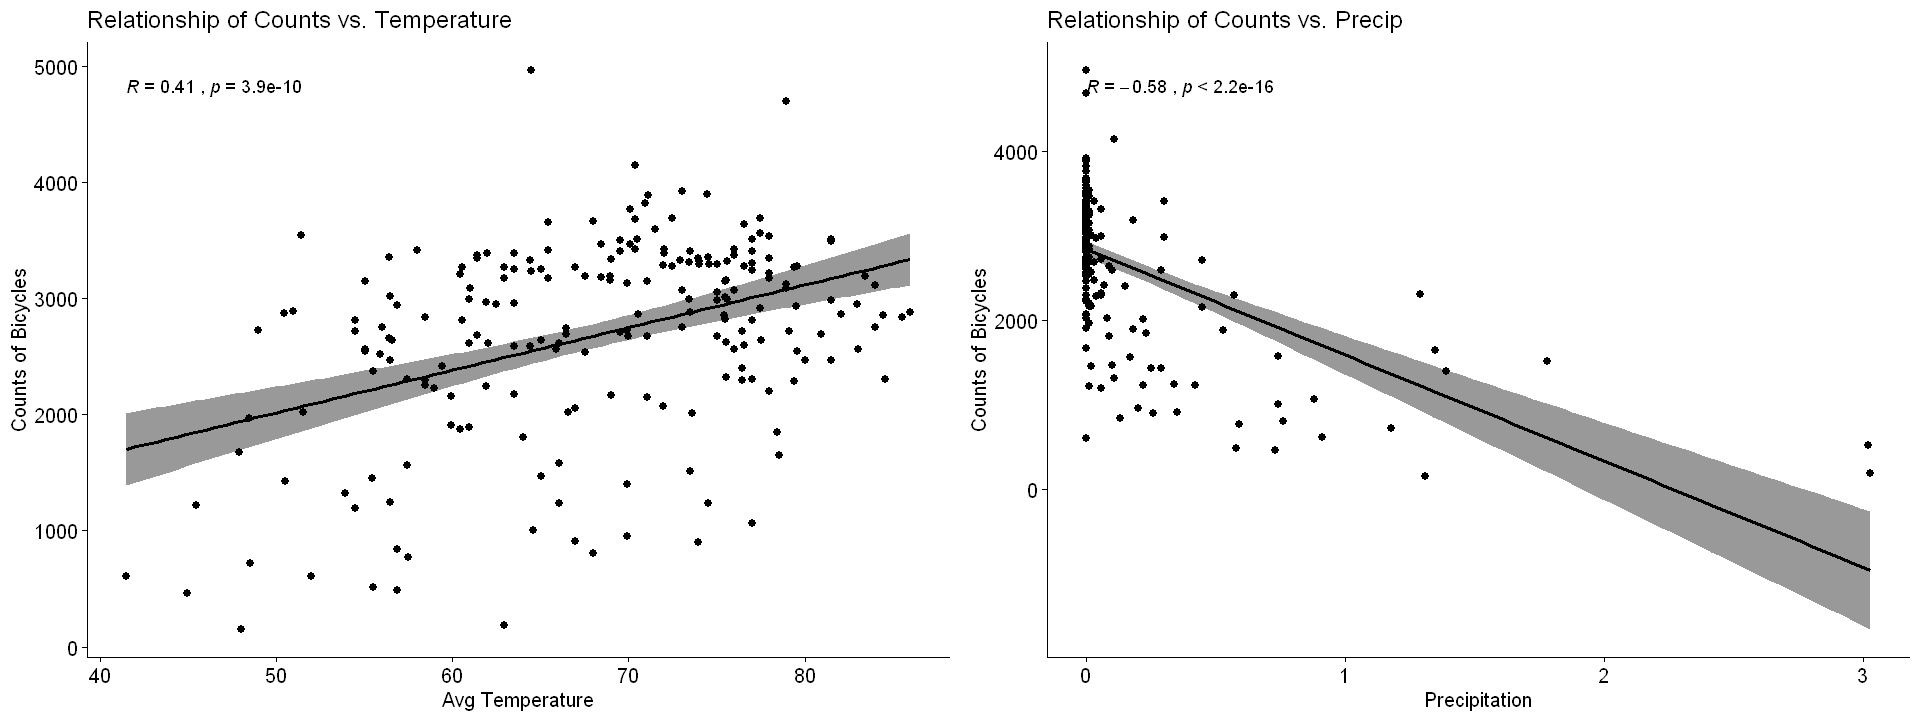

In [66]:
options(repr.plot.width=16, repr.plot.height=6)

g1=ggscatter(dataset, x = "avg_temp", y = "counts",color='black',
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson",
          xlab = "Avg Temperature", ylab = "Counts of Bicycles", title='Relationship of Counts vs. Temperature')

g2=ggscatter(dataset, x = "precip", y = "counts",color='black',
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson",
          xlab = "Precipitation", ylab = "Counts of Bicycles", title='Relationship of Counts vs. Precip')

grid.arrange(g1,g2,ncol=2)



So, it seems like Temperature and Precipitation has strong correlation with the Counts of Bicycles. Seems like High Temperature and Low Precipitation is when people use bicycles the most.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



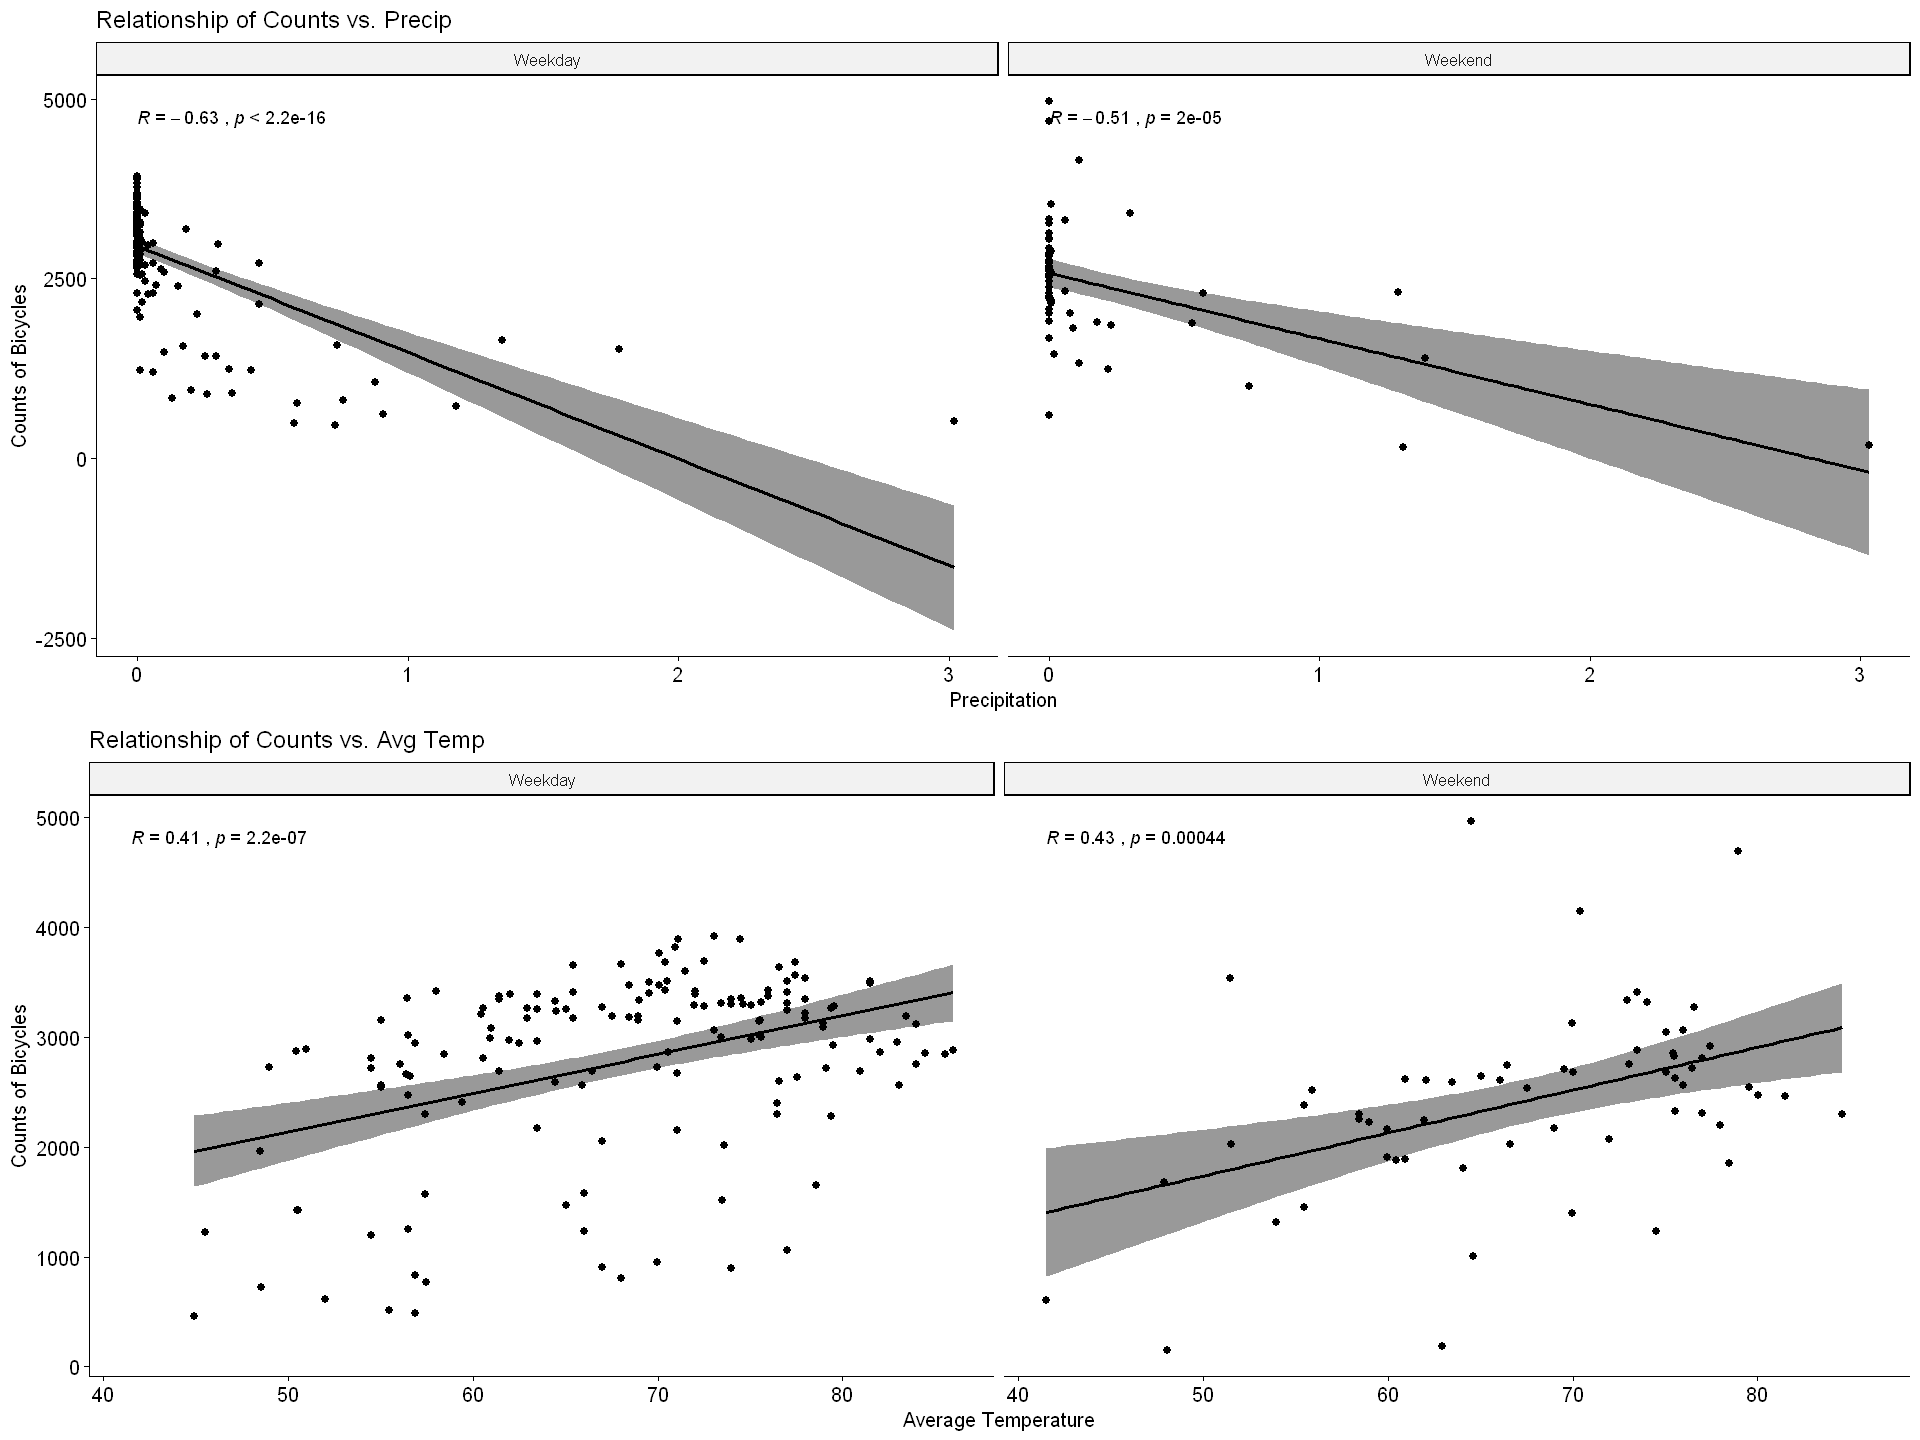

In [24]:
options(repr.plot.width=16, repr.plot.height=12)
g1=ggscatter(dataset, x = "precip", y = "counts",color='black',
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson",
          xlab = "Precipitation", ylab = "Counts of Bicycles", title='Relationship of Counts vs. Precip')+
facet_grid(~week_day_end)
g2=ggscatter(dataset, x = "avg_temp", y = "counts",color='black',
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson",
          xlab = "Average Temperature", ylab = "Counts of Bicycles", title='Relationship of Counts vs. Avg Temp')+
facet_grid(~week_day_end)

grid.arrange(g1,g2,ncol=1)

In [70]:
dataset %>% group_by(month,week_day_end) %>% summarize(avg_precip=mean(precip))

month,week_day_end,avg_precip
<dbl>,<chr>,<dbl>
4,Weekday,0.18550000
4,Weekend,0.01800000
5,Weekday,0.19782609
5,Weekend,0.19125000
6,Weekday,0.09090909
6,Weekend,0.34875000
7,Weekday,0.15952381
7,Weekend,0.08600000
8,Weekday,0.12000000


Let's do a one final check between checking if there exist any collinearity between temperature and precipitation. I would like to perform a correlation analysis on both overall and on monthly basis to see if there are any uncovered trends that i could find.

`geom_smooth()` using formula 'y ~ x'



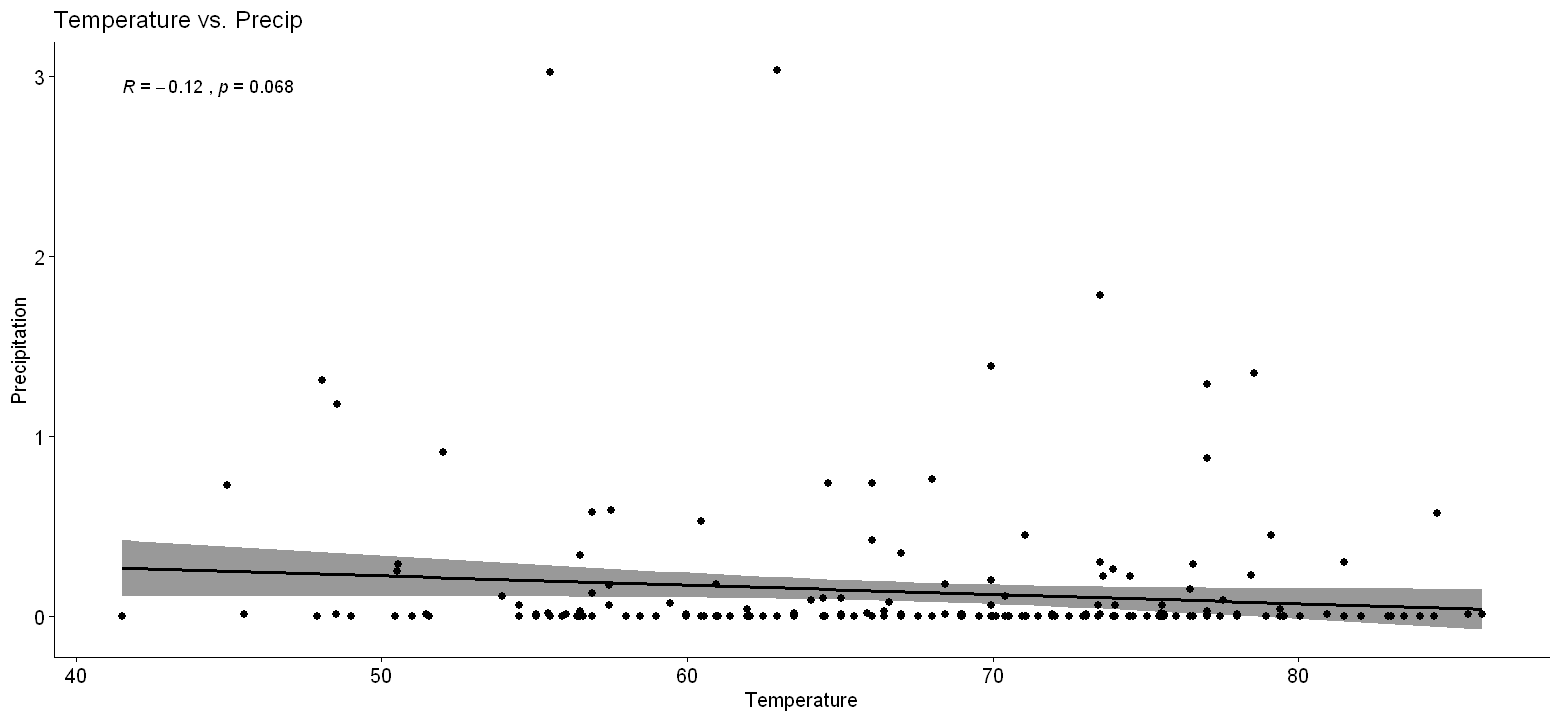

In [26]:
options(repr.plot.width=13, repr.plot.height=6)
ggscatter(dataset,x='avg_temp',y='precip',color='black',
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson",
          xlab = "Temperature", ylab = "Precipitation", title='Temperature vs. Precip')

The correlation is not significant as we can see from the p-value. Thus, we can see there isn't any significant correlation between these two variables. But i would wanna look at their correlation on monthly level. Such that i want to find out if in some specific months there is a significant correlation between the two variables.

`geom_smooth()` using formula 'y ~ x'



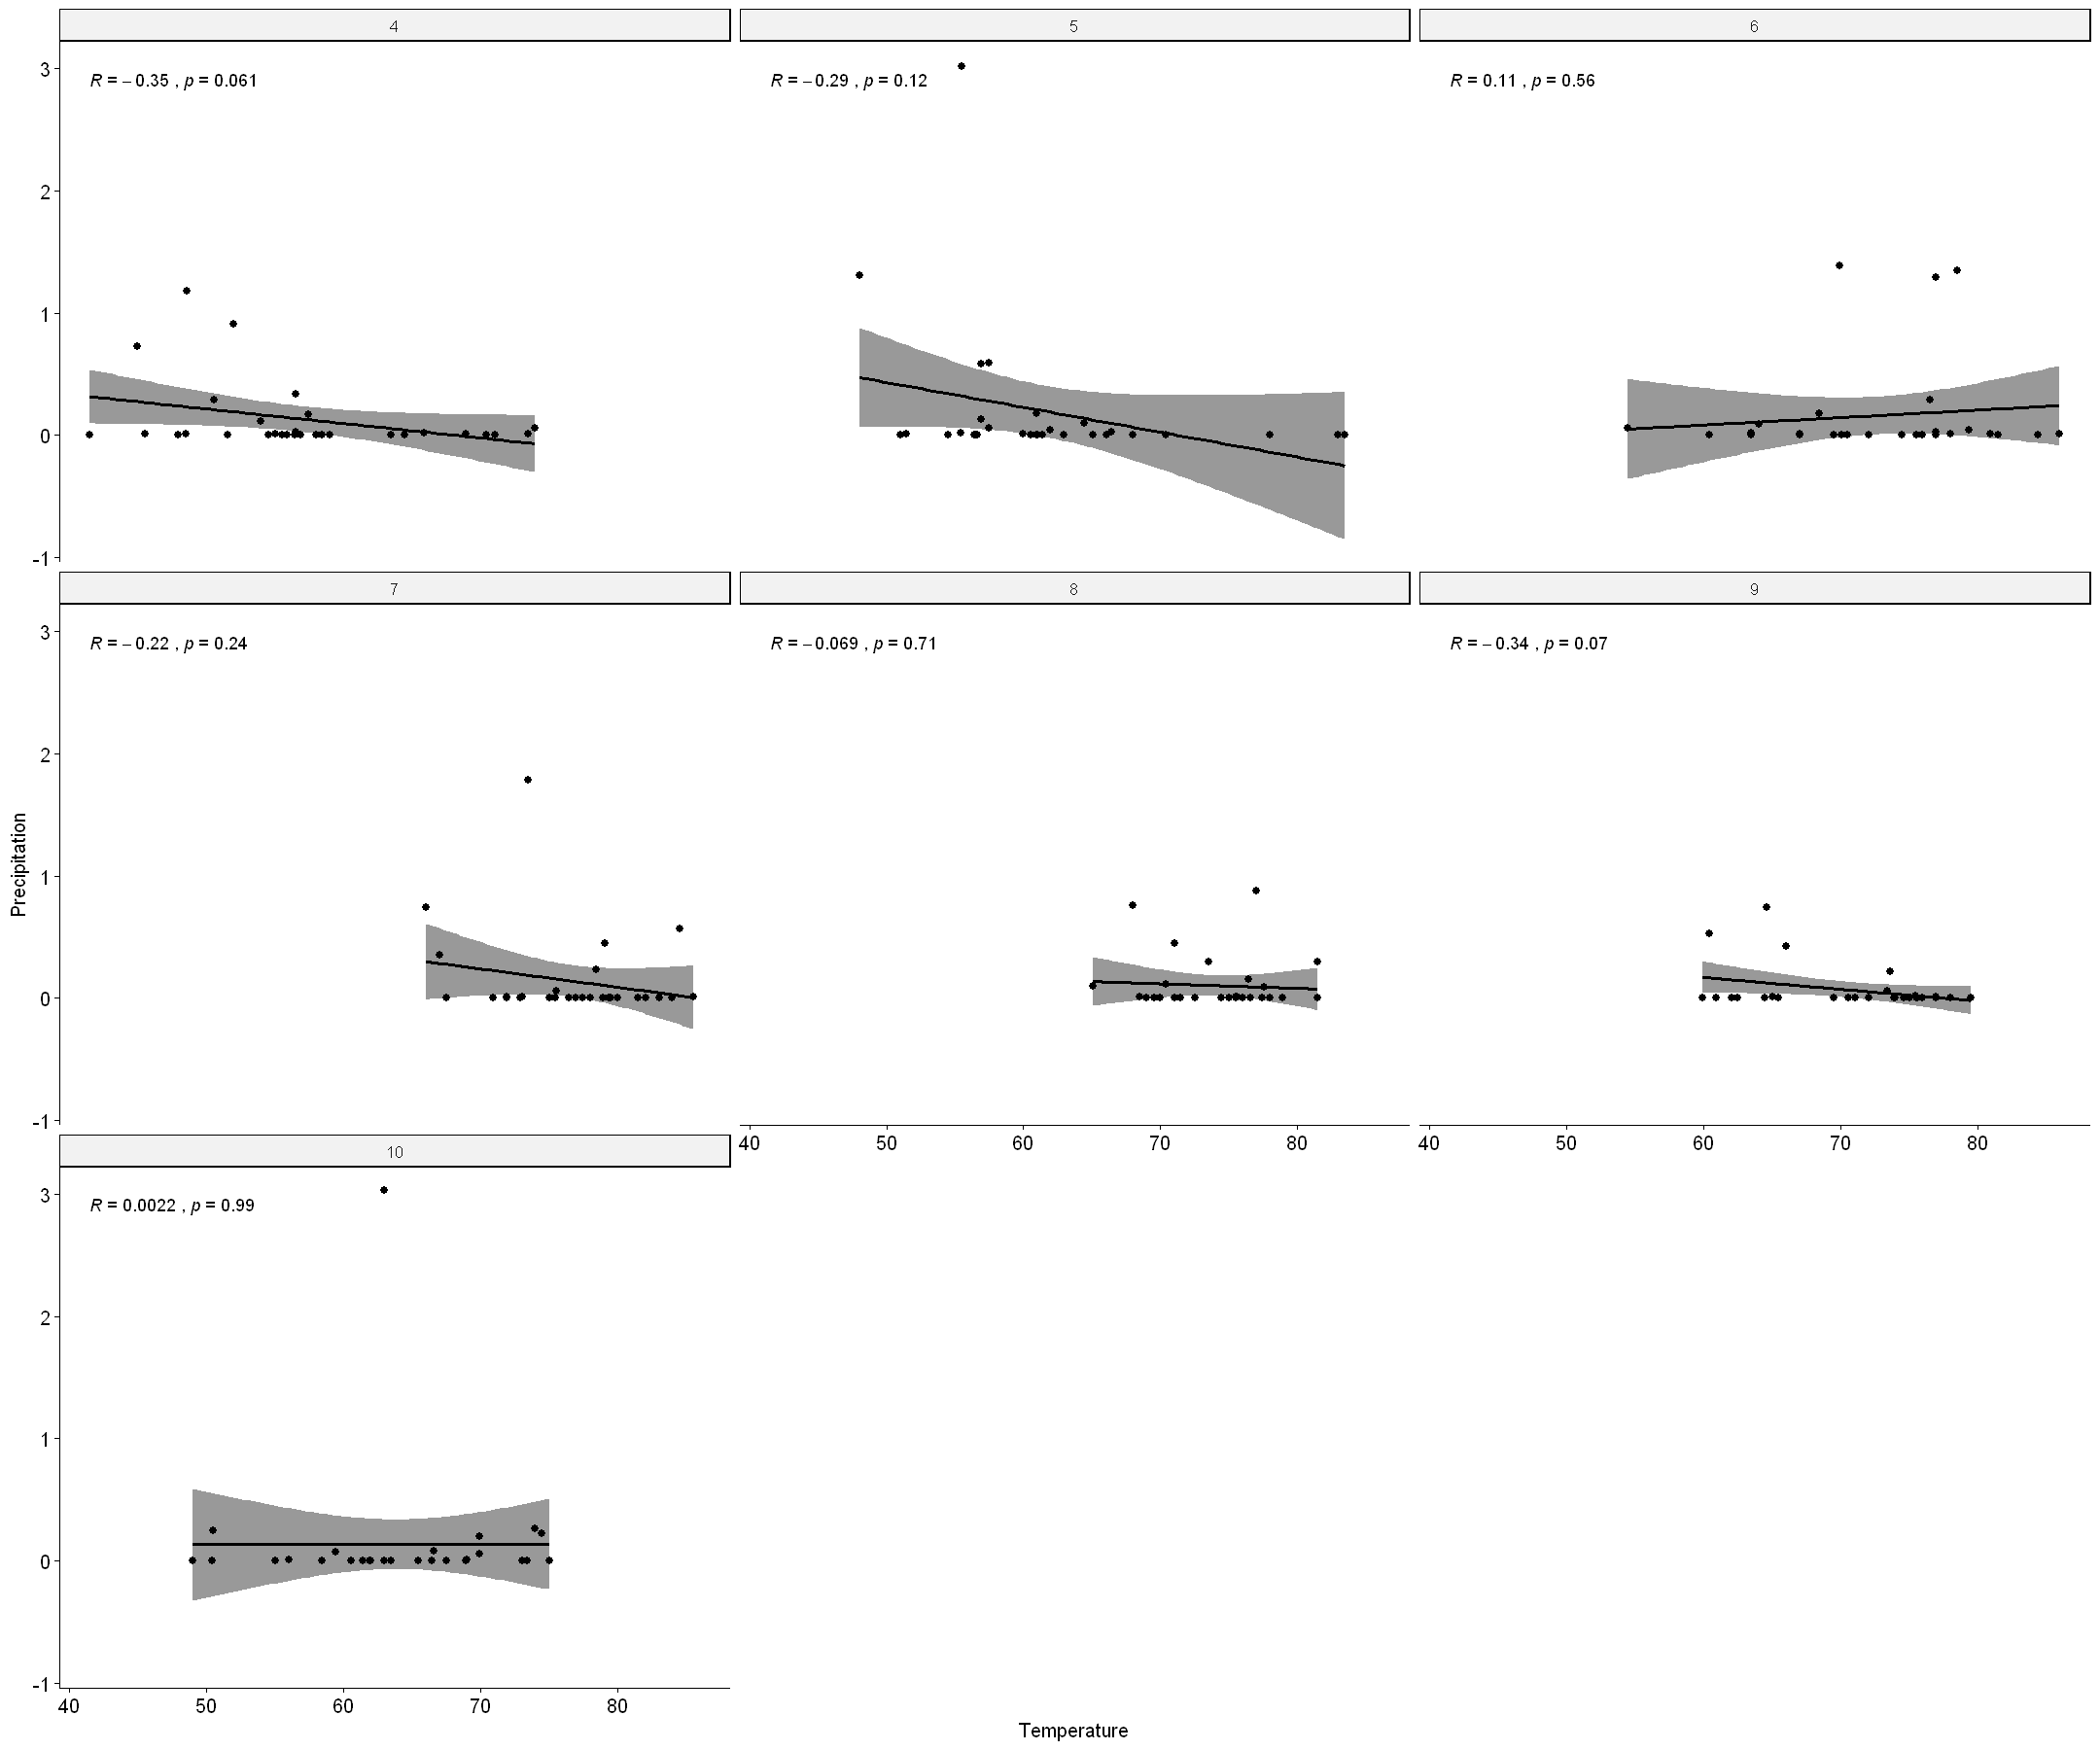

In [29]:
options(repr.plot.width=18, repr.plot.height=15)
ggscatter(dataset, x='avg_temp',y='precip',color='black',add='reg.line',conf.int=TRUE,
         cor.coef = TRUE, cor.method = "pearson",
          xlab = "Temperature", ylab = "Precipitation") + facet_wrap(~ month)

I don't see any significant correlation there. So, we are good to use both the Average Temperature and Precipitation variables in our model, where we want to model the posterior of the counts of bicycles.

Let's plot the distribution of the counts of bicycles. The distribution seems pretty much unimodek and a bit left skewed with a heavy left tail.

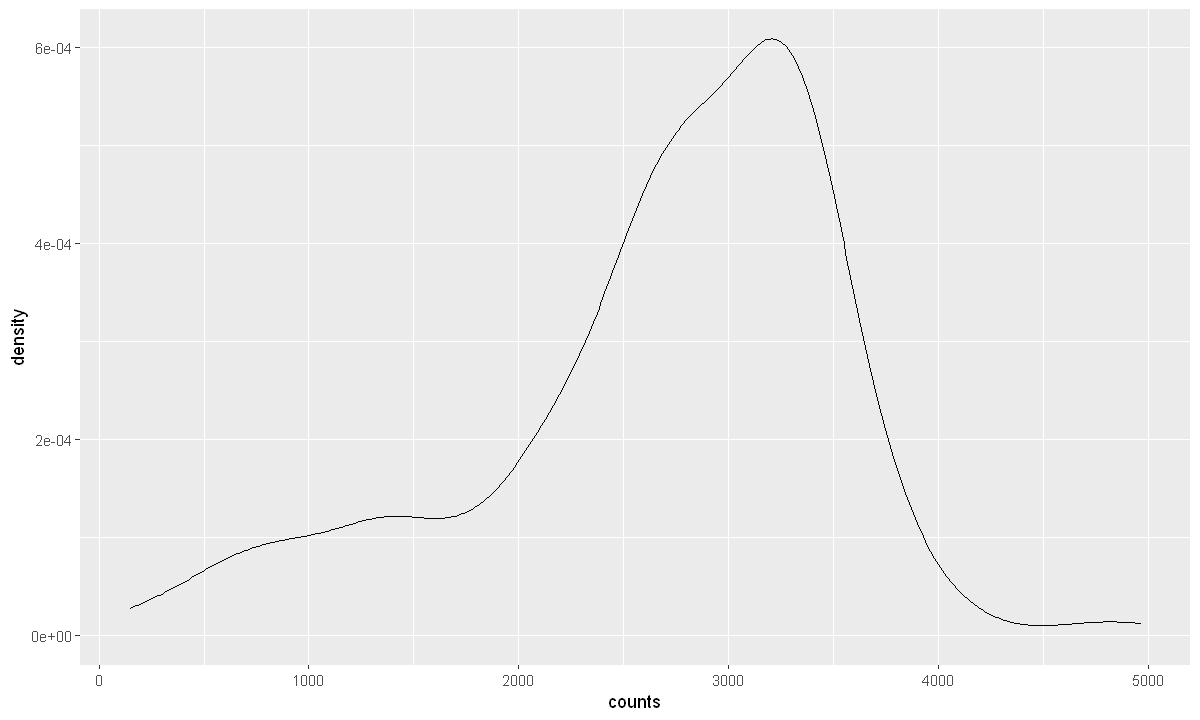

In [76]:
options(repr.plot.width=10, repr.plot.height=6)
ggplot(dataset)+geom_density(aes(x=counts))

So, by looking at the distribution of the Counts data it seems a bit of left skewed, and have a heavy left tail. Here i was thinking that maybe we can apply two models, one Simple Linear Regression Model using Normal Distribution to model the Response Variable and the other the Poisson Regression.

Modeling:
---
Model 1: (Poisson Regression):
---
Seems to me like we can explore the interaction effect of week_day_end variable with precip on our model. As, it looks like somehow precipitation on the weekend is higher than on the weekdays for almost every month.

Seems like we are gonna use avg_temp,precip,week_day_end and month as the variables to predict the counts of bicycles.
As, the Dependent variable is Counts data so, its better that we use Poisson Distribution to represent the Outcome data. For that we have to use the exponential Link function which is essentially the Poisson Regression. I would try to switch gears and use the Bayesian Modleing here. Also, i would implement the Lasso Regression Concept by using a Laplace Prior centred at zero for the coefficients of the regression.

Here i am going to define my model such that.

- counts[i] ~ Poisson (lambda[i]) where i=1,...,nrow(dataset)
- Log(lambda[i]) = b[1] + b[2]*avg_temp + b[3]*precip + b[4]*month + b[5]*week_day_end

Priors on Parameters:
- b[j] ~ Laplace(0,1) where j=1,2,3,4,5

Now, Let's apply this model in JAGS.

In [8]:
dataset_model=dataset %>% select(counts,precip,avg_temp,month,week_day_end)

In [9]:
dataset_model$month=as.factor(dataset_model$month)

In [10]:
dataset_model$avg_temp=(dataset_model$avg_temp-mean(dataset_model$avg_temp))/sd(dataset_model$avg_temp)

In [11]:
head(dataset_model)

counts,precip,avg_temp,month,week_day_end
<dbl>,<dbl>,<dbl>,<fct>,<chr>
606,0.00,-2.780559,4,Weekend
2021,0.00,-1.730581,4,Weekend
2470,0.03,-1.213428,4,Weekday
723,1.18,-2.044007,4,Weekday
2807,0.00,-1.422379,4,Weekday
461,0.73,-2.420119,4,Weekday


In [12]:
X=model.matrix(counts ~ avg_temp+precip+month+week_day_end+week_day_end*precip, data=dataset_model)

In [13]:
daty=X[,-1]
colnames(daty)[10]='precip_interaction_week_end_day'
main_dat_model=as.data.frame(cbind(counts=dataset$counts,daty))

In [14]:
mod_string = "model {
    for(i in 1:length(avg_temp)){
        counts[i] ~ dpois(lam[i])
        log(lam[i]) = b[1]+ b[2]*avg_temp[i] + b[3]*precip[i] + b[4]*month5[i] + b[5]*month6[i] +
        b[6]*month7[i] + b[7]*month8[i] + b[8]*month9[i] +b[9]*month10[i] + b[10]*week_day_endWeekend[i] +
        b[11]*precip_interaction_week_end_day[i]
    }
    
    # Setting the Priors
    
    for (j in 1:11){
        b[j] ~ ddexp(0,1/1e2)
    }
}"

In [15]:
params=c('b')

In [16]:
mod= jags.model(textConnection(mod_string),data=as.list(main_dat_model),n.chains=4)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 214
   Unobserved stochastic nodes: 11
   Total graph size: 2976

Initializing model



In [17]:
update(mod, 1e4)

In [18]:
mod_sim=coda.samples(mod,variable.names=params, n.iter=1e4)


In [19]:
mod_csim = as.mcmc(do.call(rbind,mod_sim))

In [121]:
summary(mod_sim)


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean        SD  Naive SE Time-series SE
b[1]   7.24963 0.0121450 6.073e-05      8.307e-04
b[2]   0.01050 0.0001916 9.580e-07      1.429e-05
b[3]  -1.04244 0.0093421 4.671e-05      1.058e-04
b[4]   0.02798 0.0053624 2.681e-05      1.005e-04
b[5]   0.03261 0.0058201 2.910e-05      1.421e-04
b[6]  -0.01146 0.0062088 3.104e-05      1.696e-04
b[7]   0.11218 0.0058031 2.902e-05      1.492e-04
b[8]   0.05724 0.0056669 2.833e-05      1.253e-04
b[9]   0.03145 0.0053429 2.671e-05      1.027e-04
b[10] -0.12981 0.0031694 1.585e-05      2.917e-05
b[11]  0.39191 0.0135139 6.757e-05      1.512e-04

2. Quantiles for each variable:

          2.5%      25%      50%      75%      97.5%
b[1]   7.22561  7.24152  7.24997  7.25814  7.2726532
b[2]   0.01013  0.01036  0.01049  0.01062  0.0108907
b[3]  -1

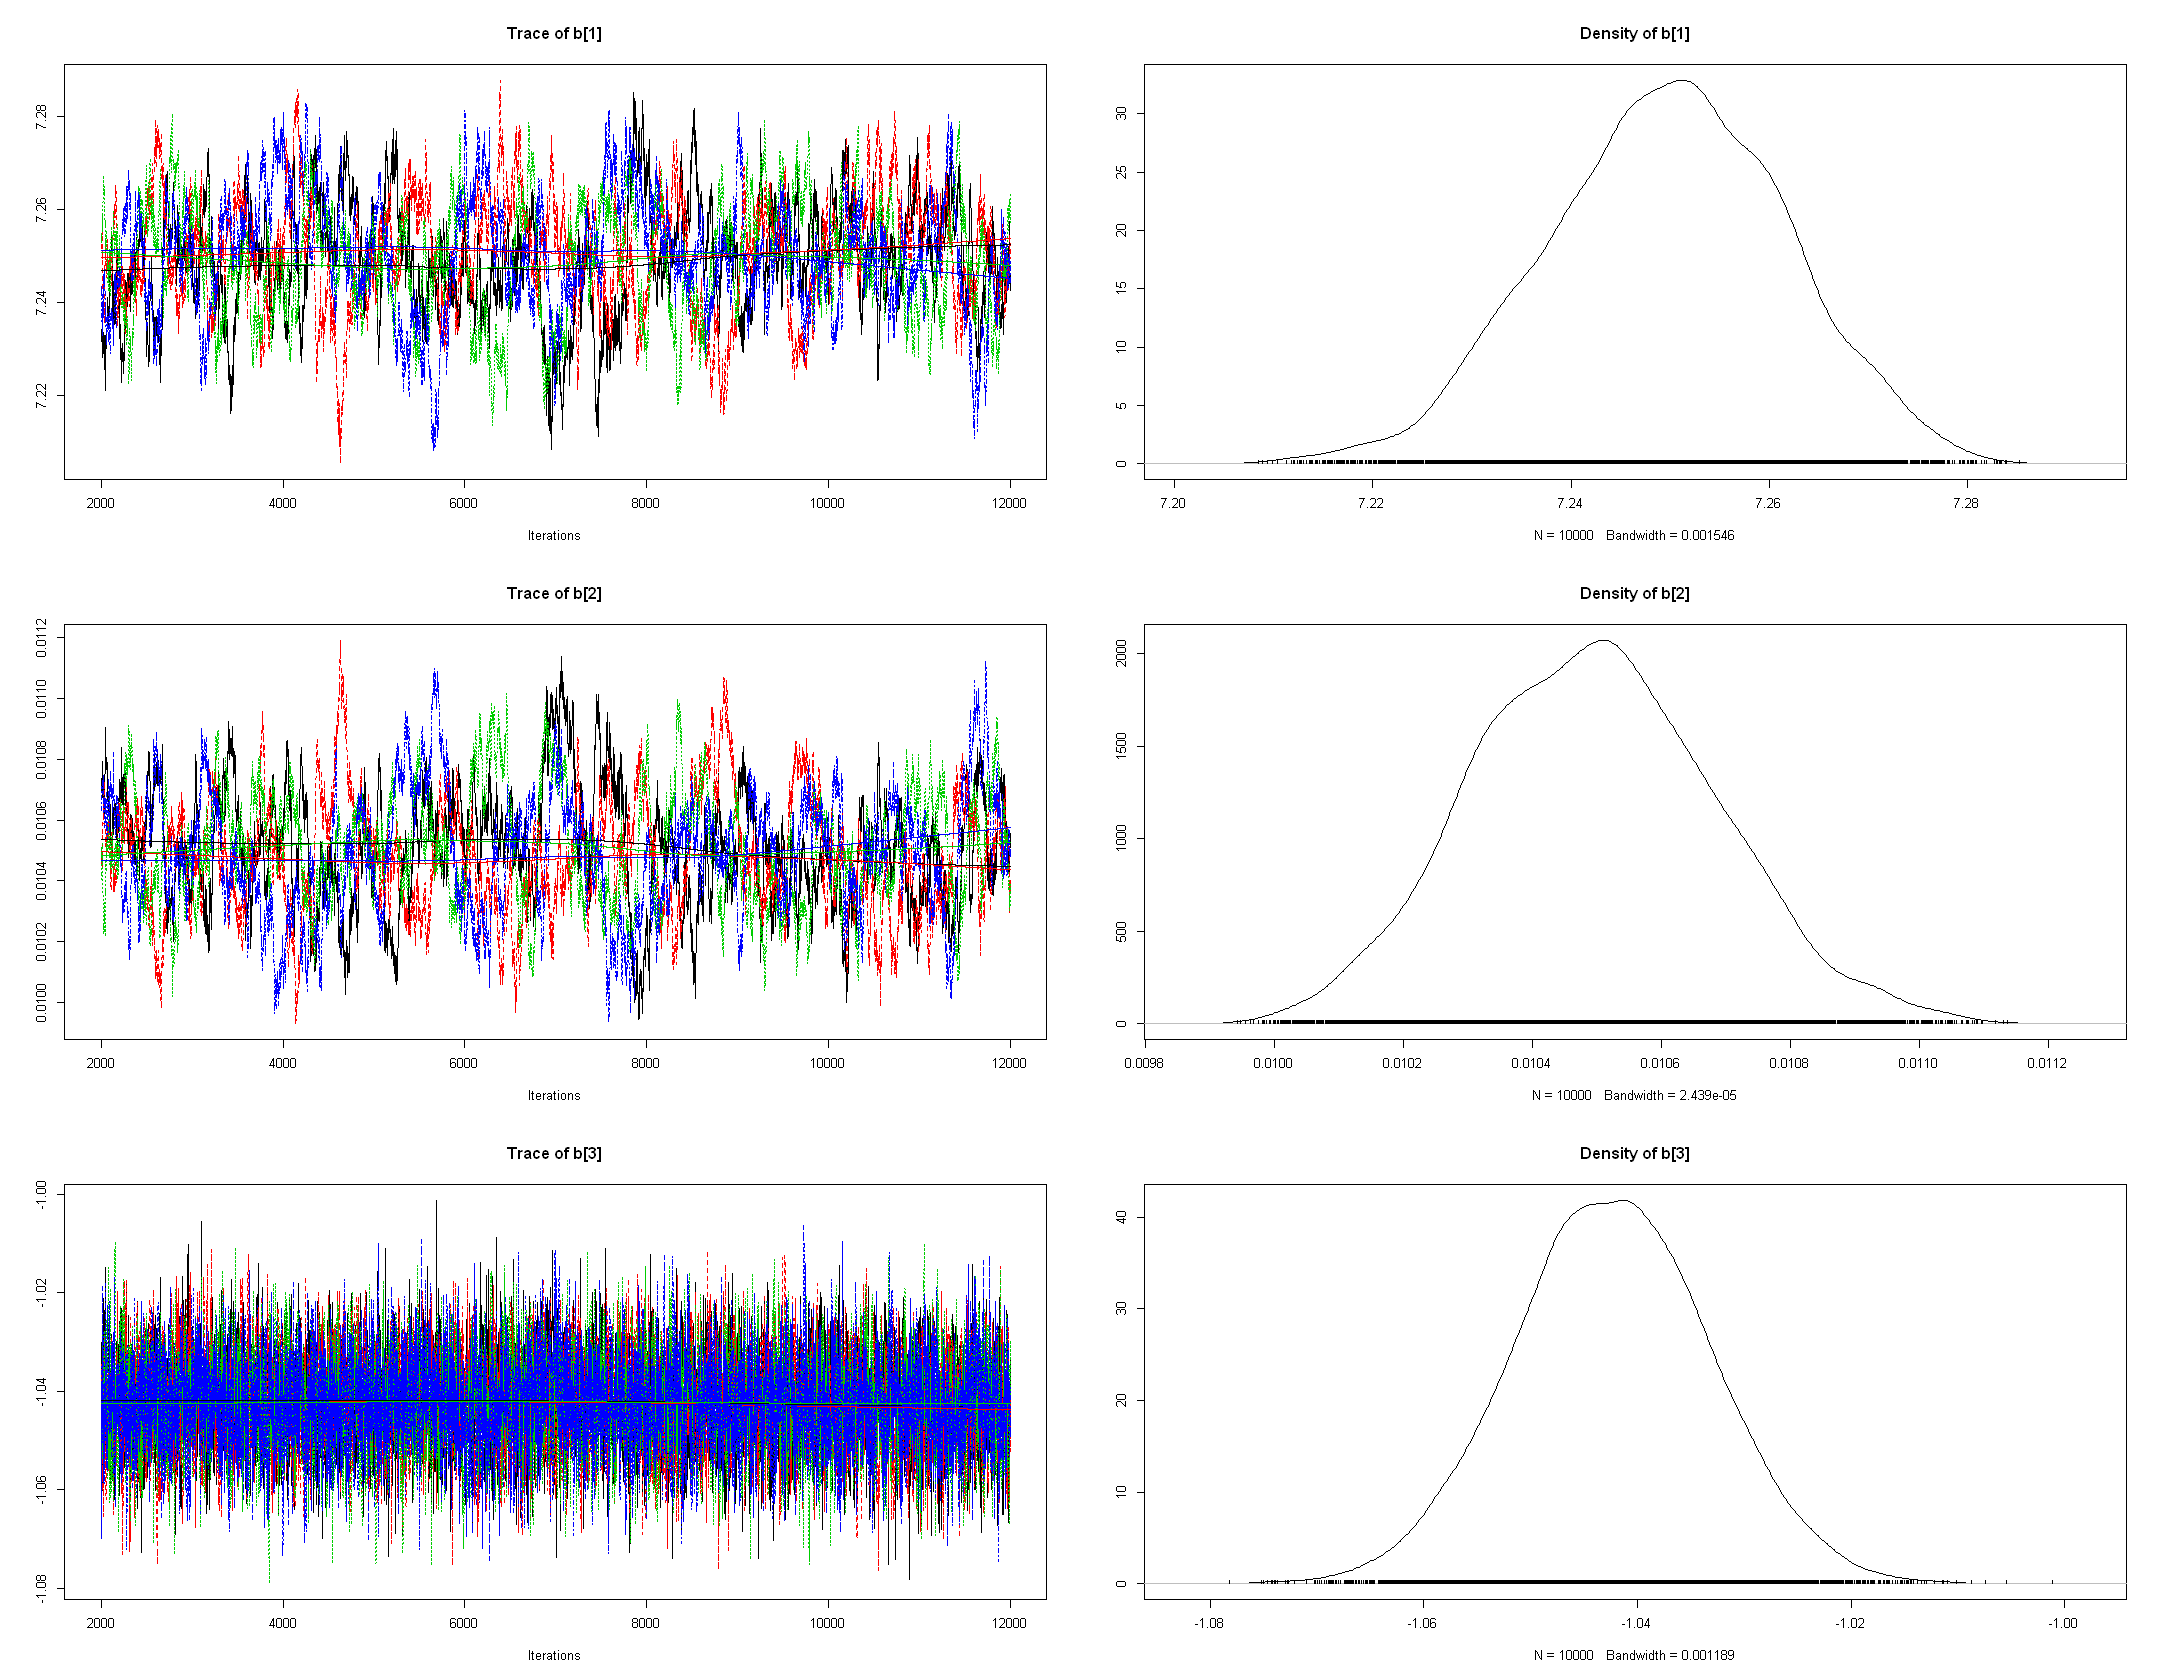

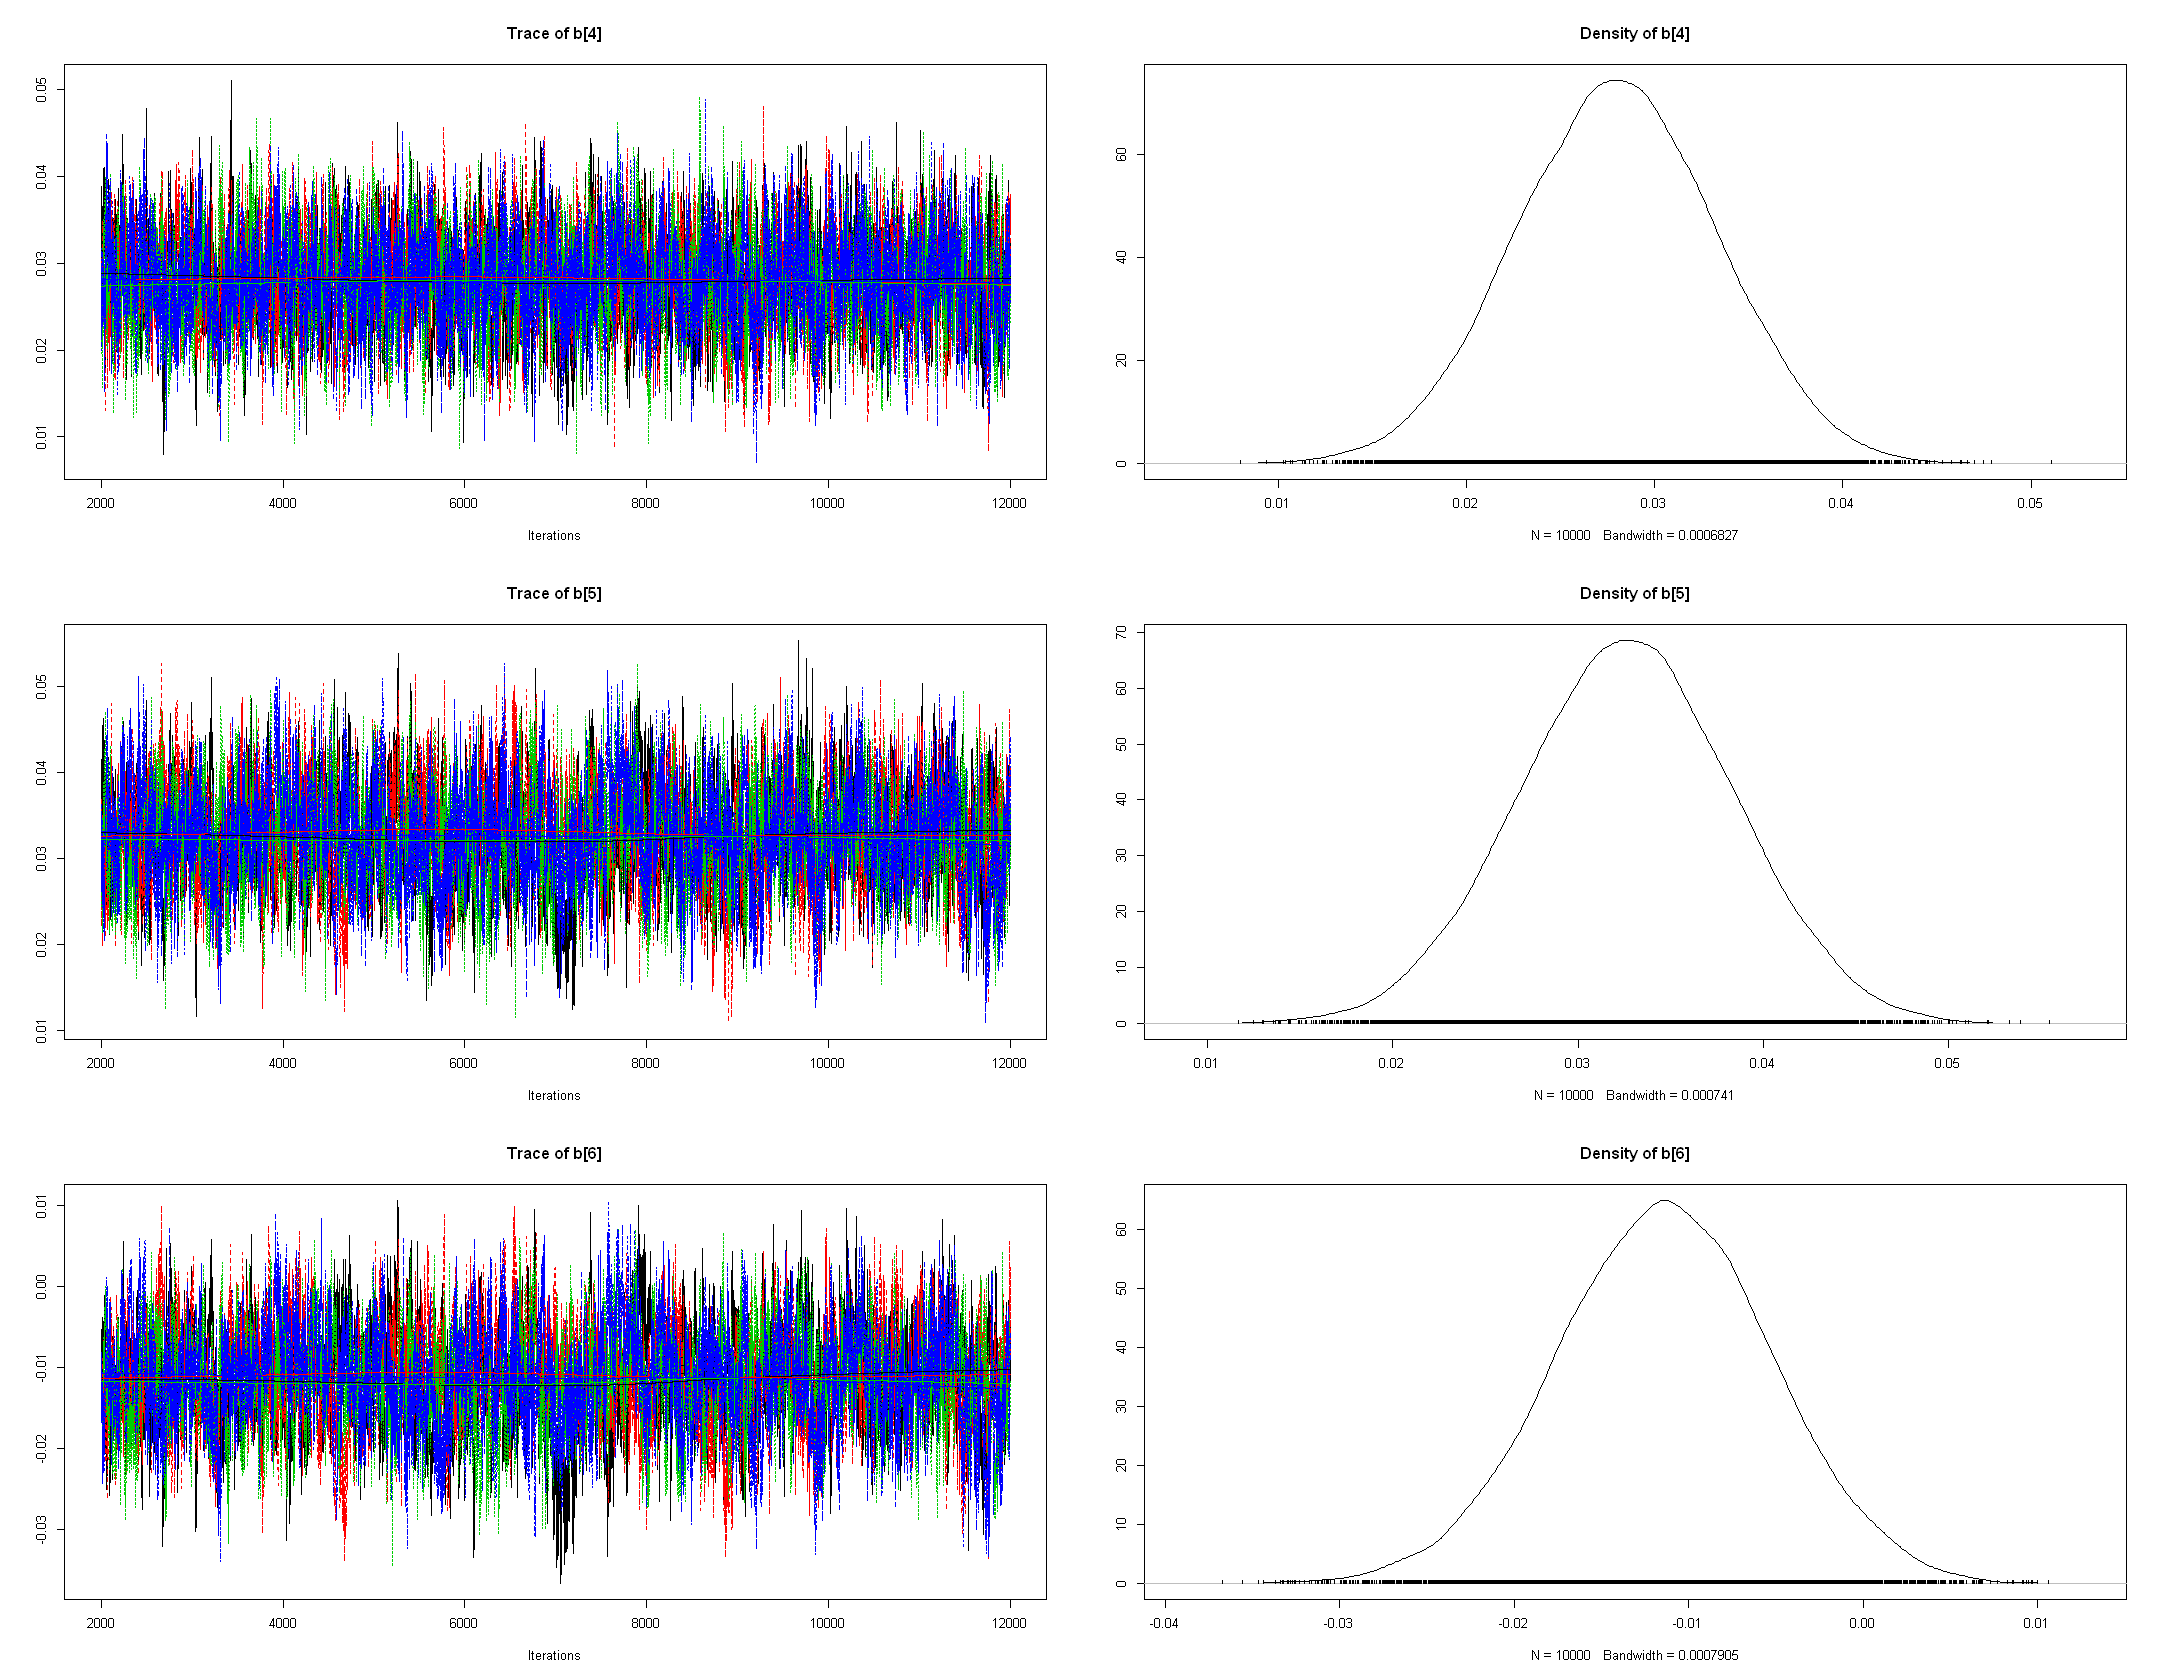

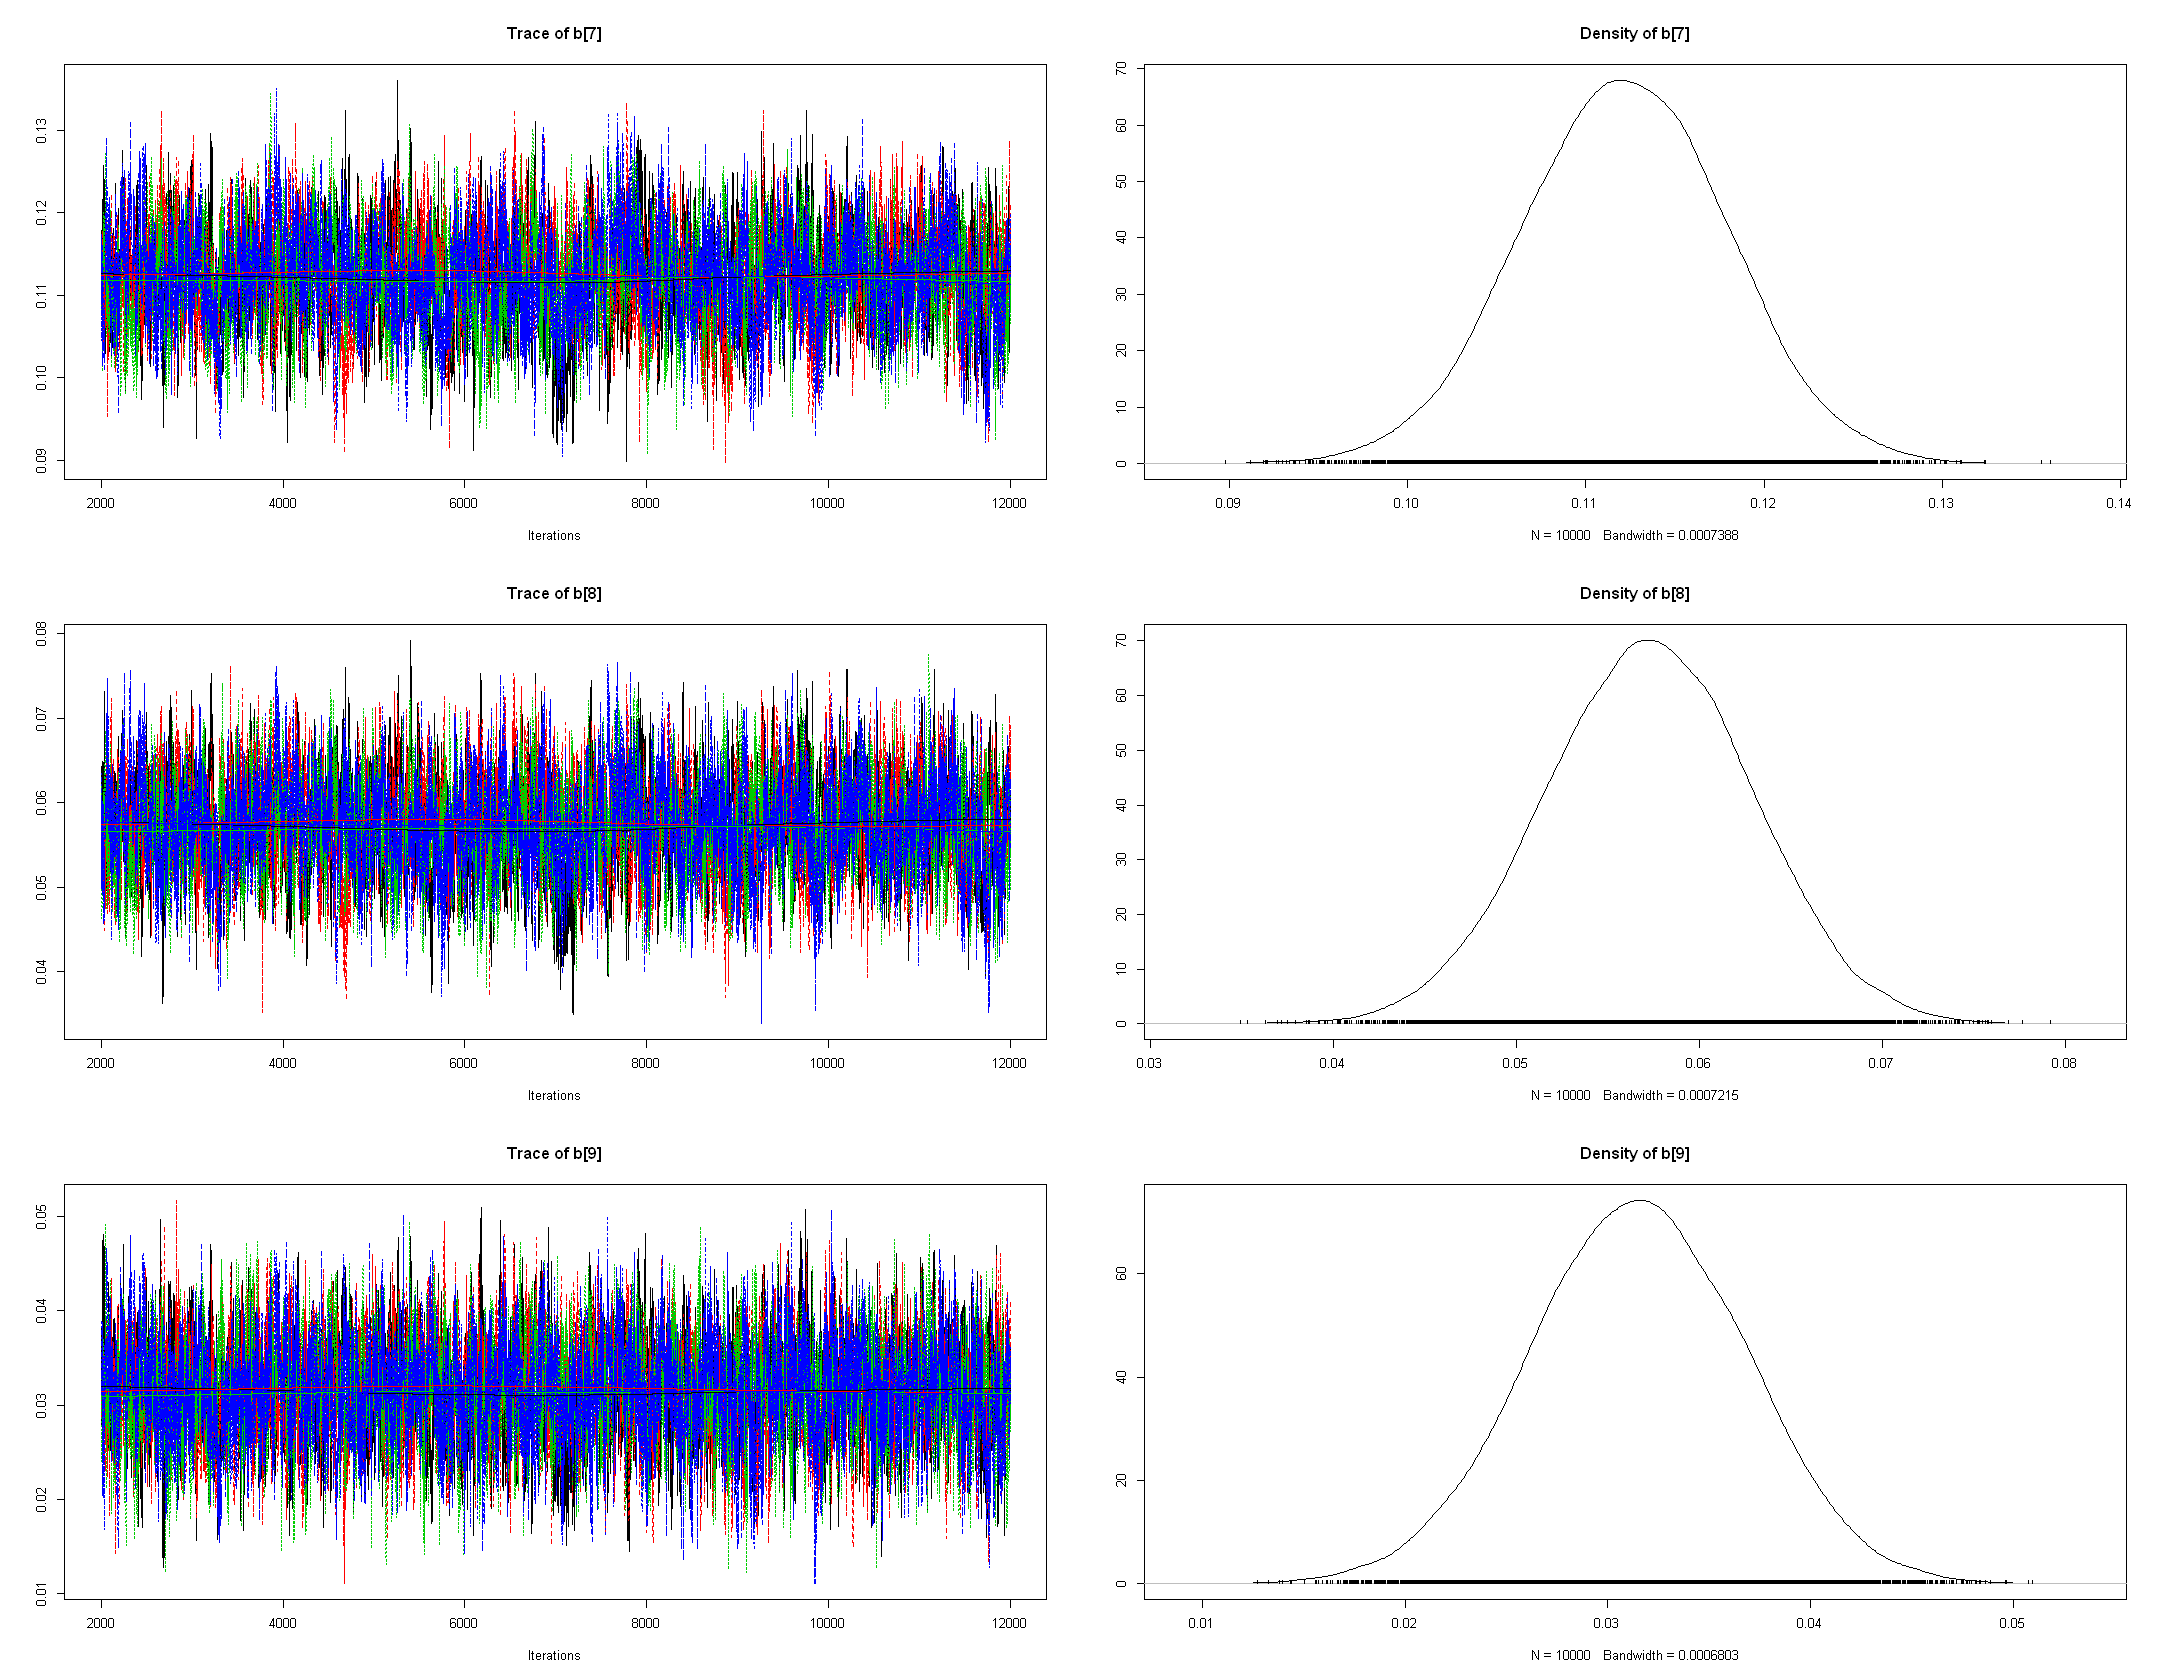

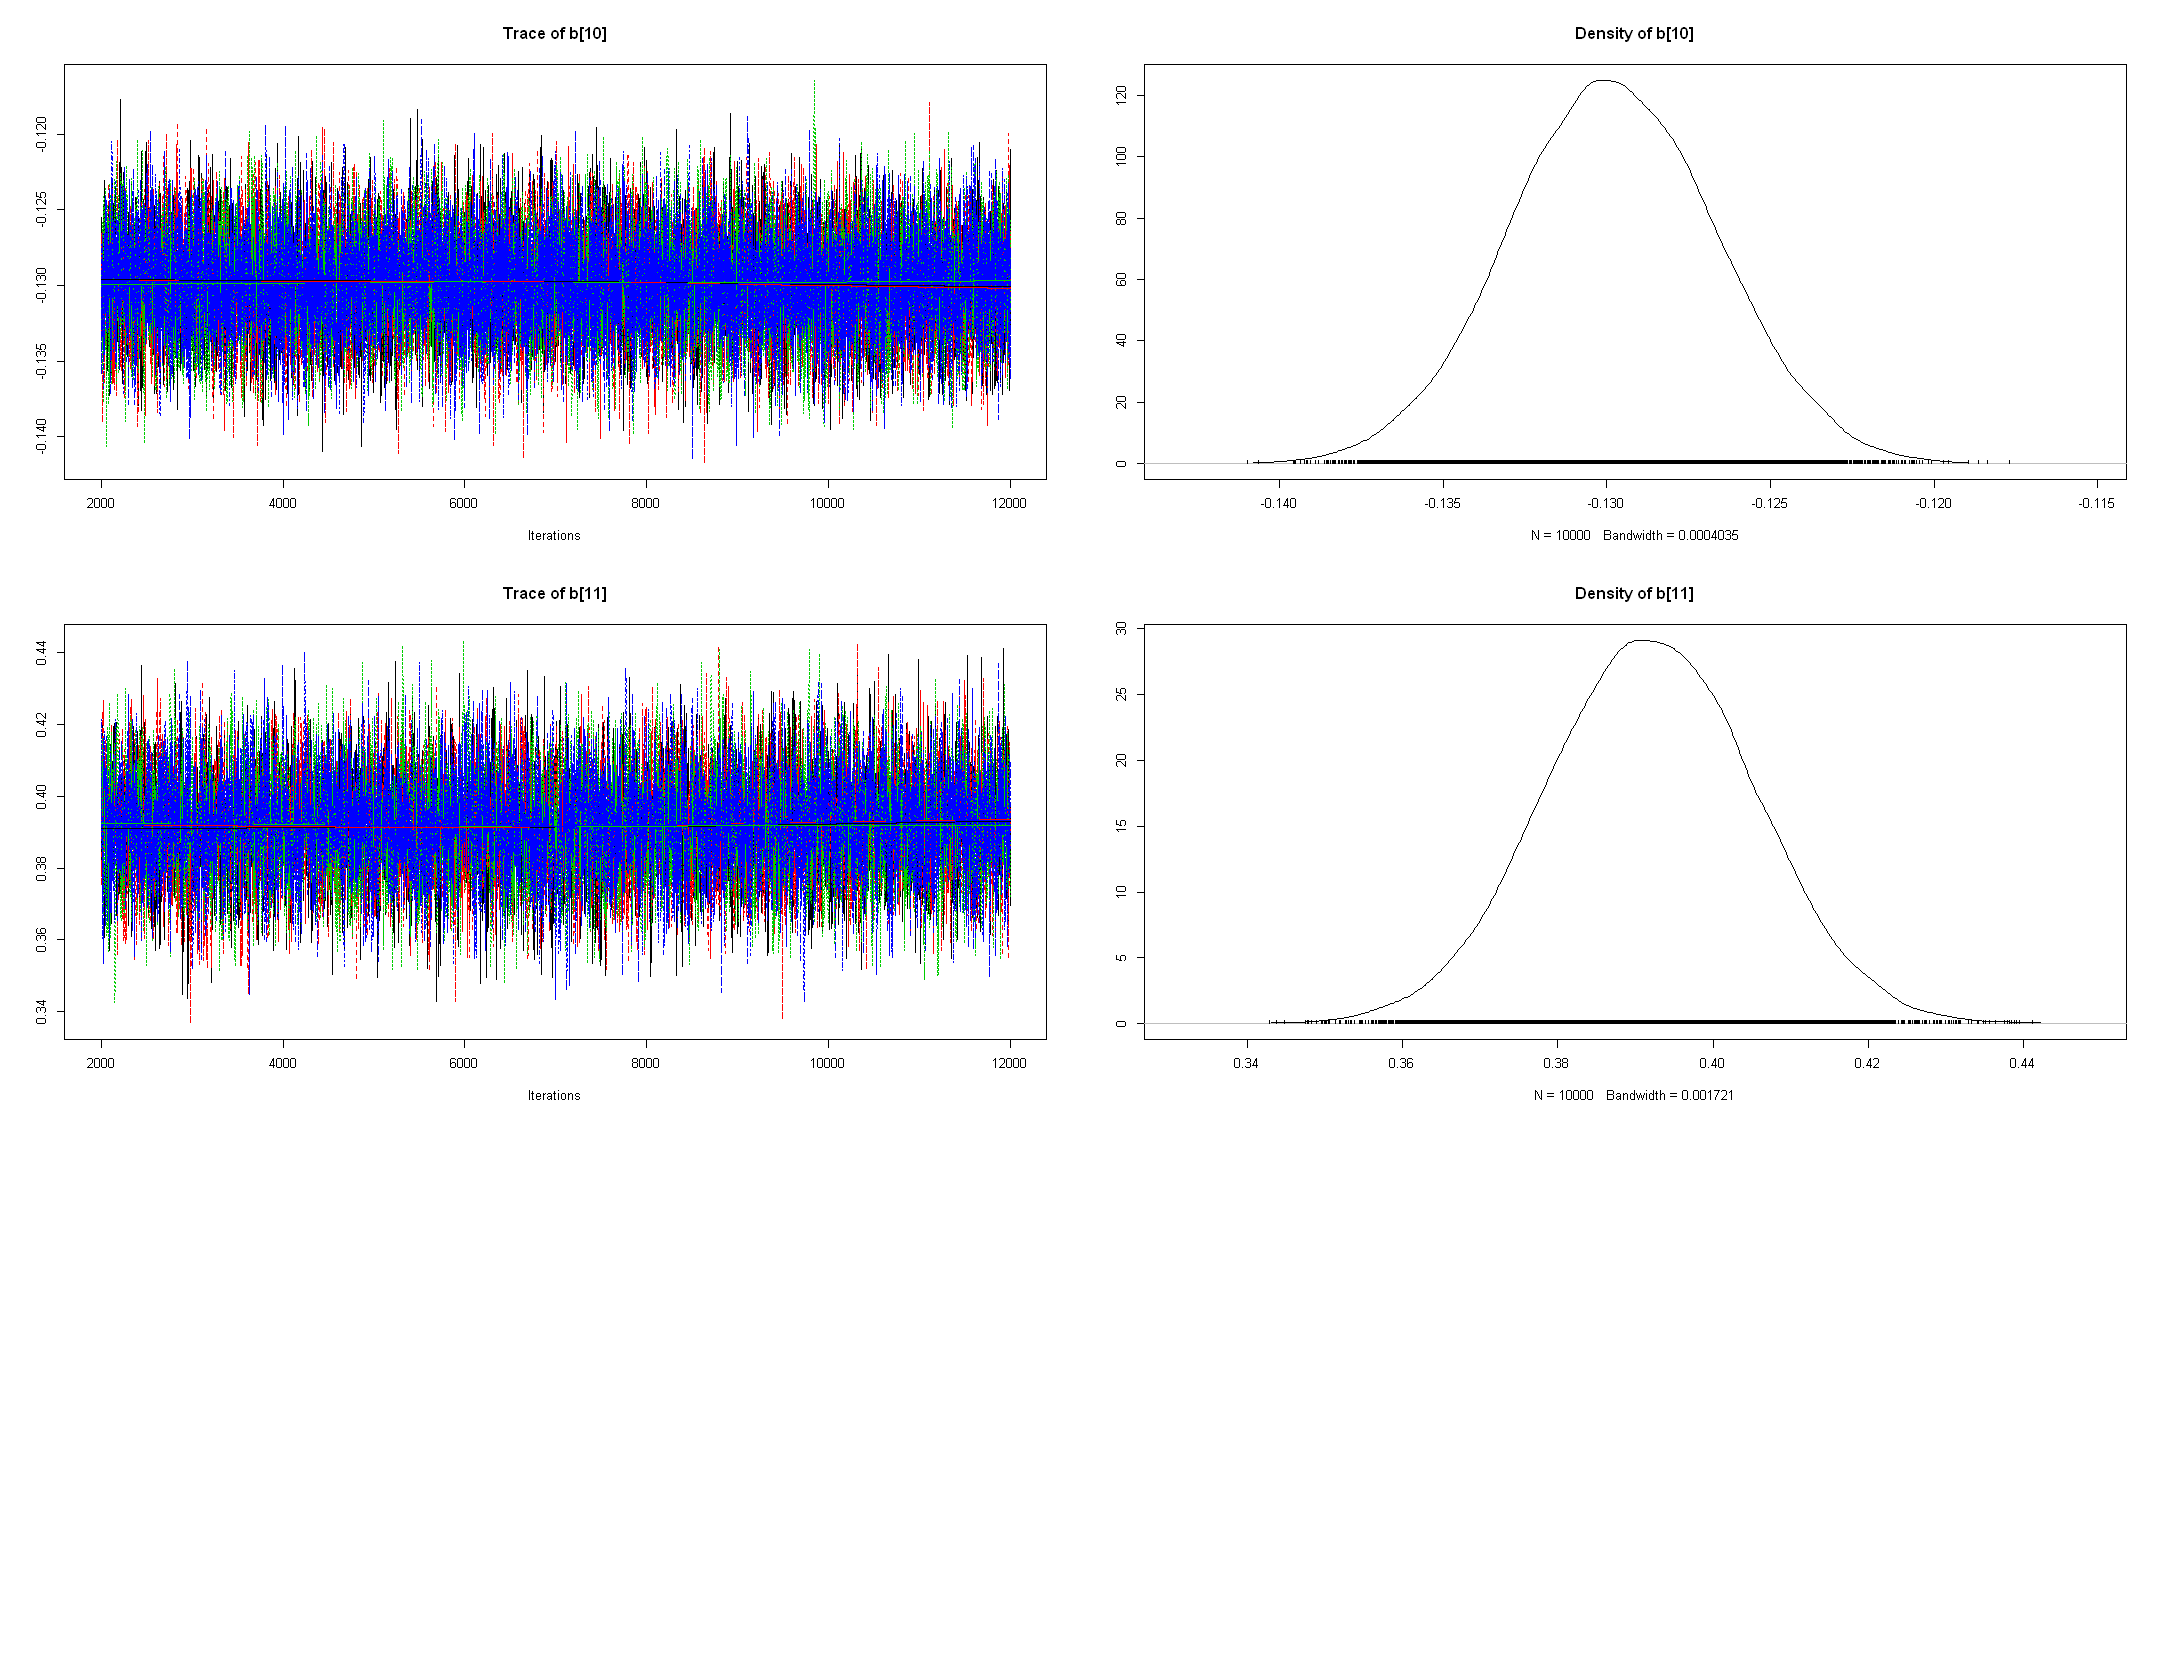

In [131]:
options(repr.plot.width=18, repr.plot.height=14)
plot(mod_sim)

The plots tells us the chains have converged well. Also, from the posterior mean estimates of parameters and their posterior distributions, we can see that the "Precipitation", "Week_day_end" and their interaction term has mean estimate of parameters above zero, even though i put a strict prior of Laplace peaked at zero, this means that these variables are of prime importance in predicting the counts of bicycles. For temperature the estimate of the parameter is pretty close to zero showing not much of a significant effect. Also, for temperature variable the chains wandered around a bit too much showing unstable estimate or lack of convergence.

Now, Let's check the gelman diagonostic and Auto Correlations.

In [132]:
gelman.diag(mod_sim)

Potential scale reduction factors:

      Point est. Upper C.I.
b[1]        1.01       1.02
b[2]        1.01       1.02
b[3]        1.00       1.00
b[4]        1.00       1.00
b[5]        1.00       1.01
b[6]        1.00       1.01
b[7]        1.00       1.01
b[8]        1.00       1.00
b[9]        1.00       1.00
b[10]       1.00       1.00
b[11]       1.00       1.00

Multivariate psrf

1.01

In [127]:
autocorr.diag(mod_sim)

,b[1],b[2],b[3],b[4],b[5],b[6],b[7],b[8],b[9],b[10],b[11]
Lag 0,1.0000000,1.0000000,1.00000000,1.000000000,1.00000000,1.0000000,1.0000000,1.00000000,1.00000000,1.00000000,1.000000000
Lag 1,0.9892085,0.9912161,0.62321792,0.619256067,0.70666585,0.7499390,0.7406704,0.69977160,0.63764411,0.44059532,0.616204600
Lag 5,0.9484649,0.9567801,0.14630384,0.392516149,0.50366439,0.5563784,0.5360241,0.48508885,0.41062240,0.04986562,0.143047609
Lag 10,0.9009489,0.9148083,0.04296102,0.256454199,0.36008982,0.4279638,0.3943464,0.34082205,0.26415782,0.02295244,0.034992894
Lag 50,0.6157260,0.6430859,0.00126454,0.000461955,0.09275032,0.1602594,0.1205257,0.07355205,0.01710867,0.01180110,-0.002250038


Apart for the parameter for Temperature, the Auto Correlations is fading away quickly for all other parameter estimates. Which shows the convergence and stability of these estimates.

In [129]:
params=colMeans(mod_csim)
params

b[1]        b[2]        b[3]        b[4]        b[5]        b[6] 
 7.24962832  0.01049571 -1.04243966  0.02798047  0.03260589 -0.01146331 
       b[7]        b[8]        b[9]       b[10]       b[11] 
 0.11218176  0.05723765  0.03144594 -0.12981342  0.39190993

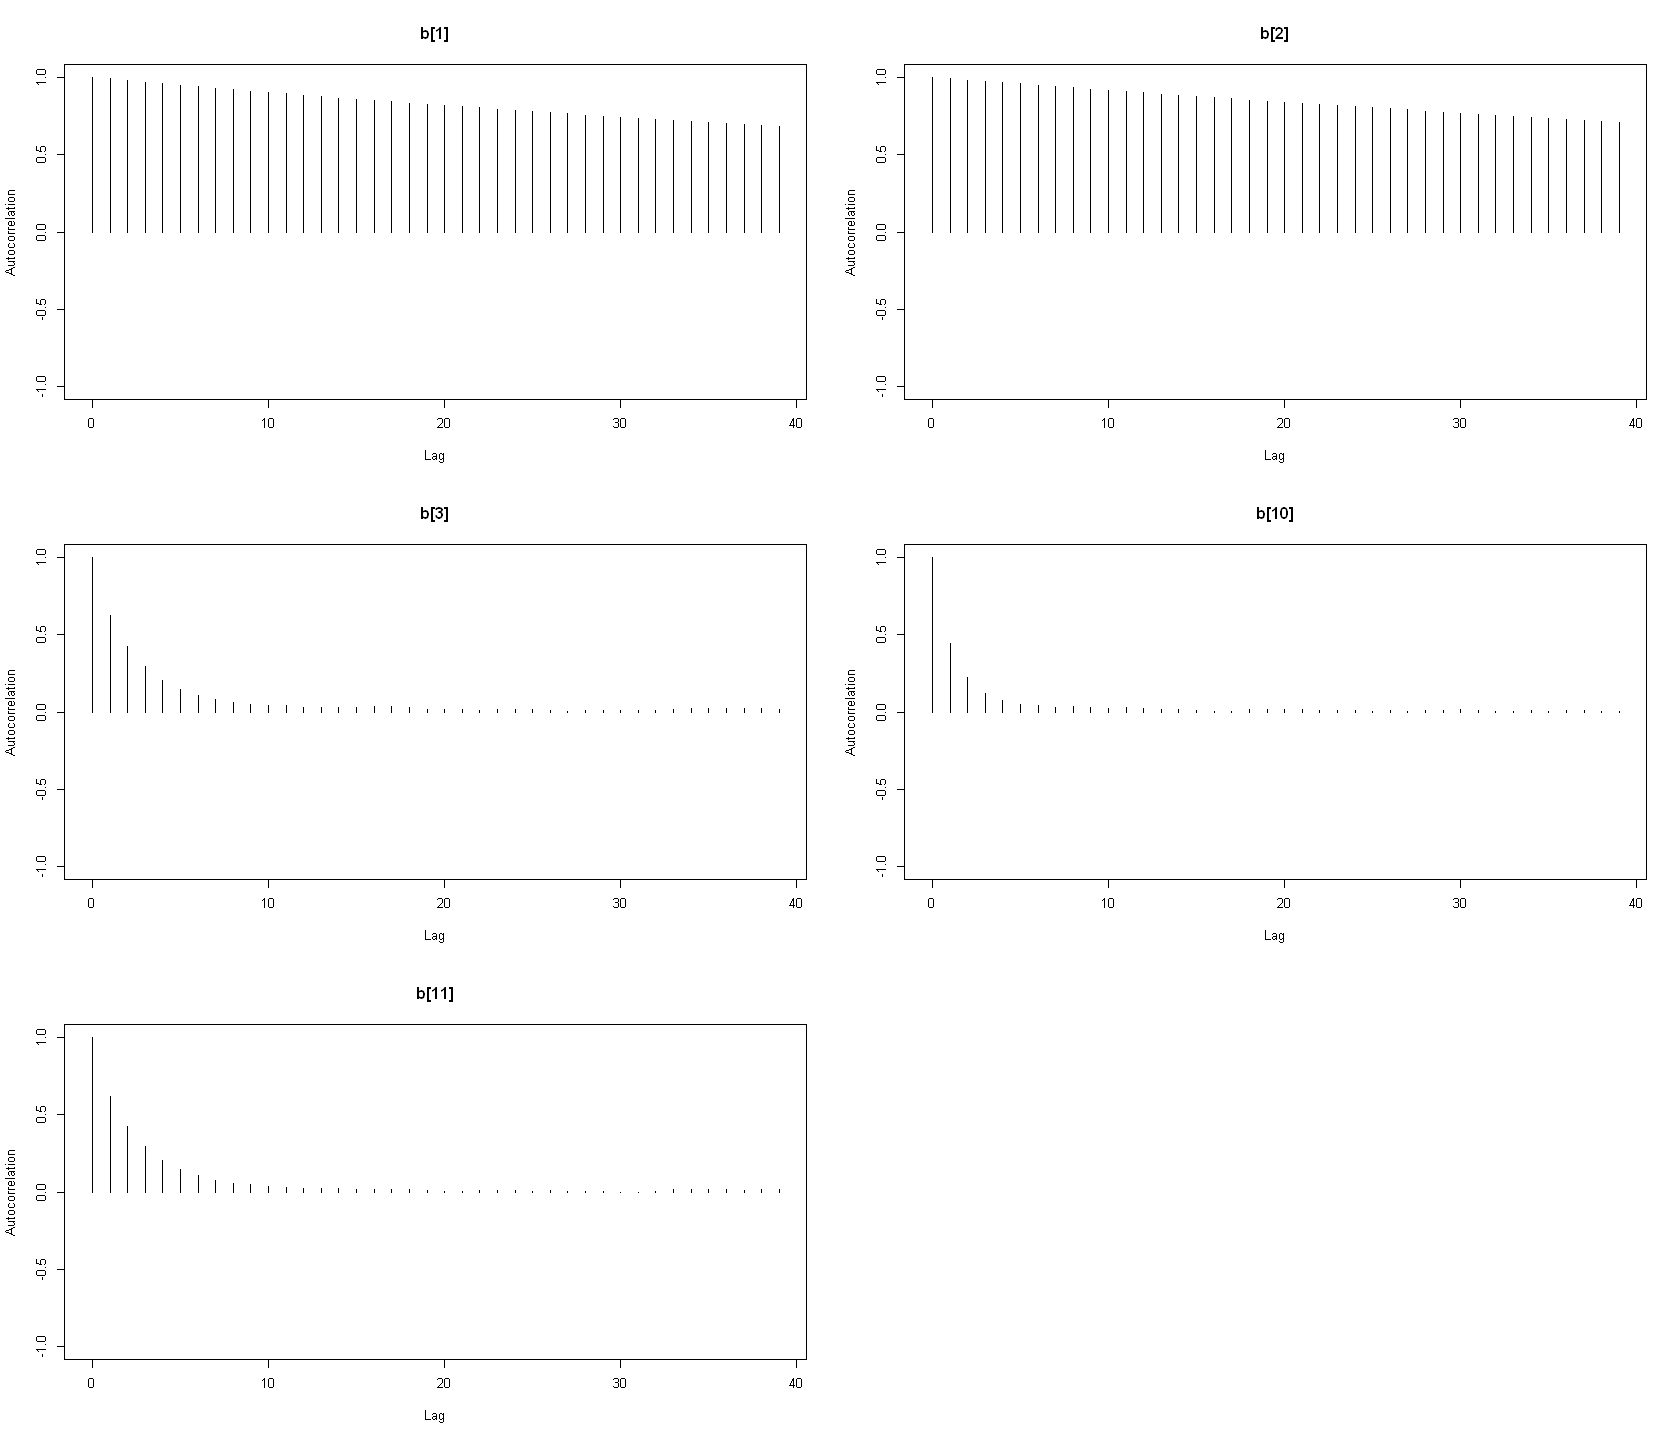

In [133]:
options(repr.plot.width=14, repr.plot.height=12)
autocorr.plot(mod_csim[,c(1,2,3,10,11)])

Here, I checked the Autocorrelation for Intercept Term, Temperature, Precipitation, WeekEnd_Term_Variable and the Interaction Term. We can see the strong correlation in Temperature Variable Parameter. Thus, we could eliminate it and then model again for better Posterior Predictive Distribution of Counts.

Below are the Posterior Paramter estimates for our variables used in the model. Let us generate the Posterior Distribution of the Counts using the Posterior Estimates of the Parameters.

In [137]:
counts_posterior=exp(params[1]+ X[,-1] %*% params[-1])

Here in place of X[,-1], we can use new data with all the respective parameters and derive the predictive estimates easily.

Model 2 (Normal Regression using Normal Likelihood):
---

In [57]:
mod2_string = "model {
    for(i in 1:length(avg_temp)){
        counts[i] ~ dnorm(mu[i],prec)
        mu[i] = b[1]+ b[2]*avg_temp[i] + b[3]*precip[i] + b[4]*month5[i] + b[5]*month6[i] +
        b[6]*month7[i] + b[7]*month8[i] + b[8]*month9[i] +b[9]*month10[i] + b[10]*week_day_endWeekend[i] +
        b[11]*precip_interaction_week_end_day[i]
    }
    
    # Setting the Priors
    prec ~ dbeta(1/2,1/2)
    sig2 = 1/prec
    sig= sqrt(sig2)
    
    for (j in 1:11){
        b[j] ~ ddexp(0,1/1e2)
    }
}"

params2= c('sig','b')

In [58]:
mod2= jags.model(textConnection(mod2_string),data=as.list(main_dat_model),n.chains=4)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 214
   Unobserved stochastic nodes: 12
   Total graph size: 2773

Initializing model



In [59]:
update(mod2,1e4)

In [60]:
mod2_sim=coda.samples(mod2,variable.names=params2,n.iter=5e4)

In [61]:
mod2_csim=as.mcmc(do.call(rbind,mod2_sim))

In [62]:
summary(mod2_sim)


Iterations = 11001:61000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
b[1]   2819.819  66.85  0.14947        0.36111
b[2]    280.608  48.47  0.10837        0.17615
b[3]  -1034.184 121.09  0.27077        0.45579
b[4]     32.468  84.42  0.18876        0.29841
b[5]      8.931  83.65  0.18704        0.30797
b[6]    -63.432  95.88  0.21439        0.38748
b[7]    120.882 107.78  0.24100        0.43132
b[8]     60.310  91.36  0.20429        0.34315
b[9]     36.045  84.71  0.18943        0.30408
b[10]  -176.572  92.33  0.20645        0.35604
b[11]    39.221 110.45  0.24697        0.41846
sig     626.217  31.34  0.07007        0.09304

2. Quantiles for each variable:

          2.5%       25%       50%      75%    97.5%
b[1]   2686.92  2775.346  2820.469 2865.079 2949.461
b[2]    185.61   248.015   280.533  313.398  375.

In this summary we can see that the parameter estimates have high variance indicating unstablility. LEt's check the diagnostics plots where we are gonna look at convergence of chains for all the paramter estimates.

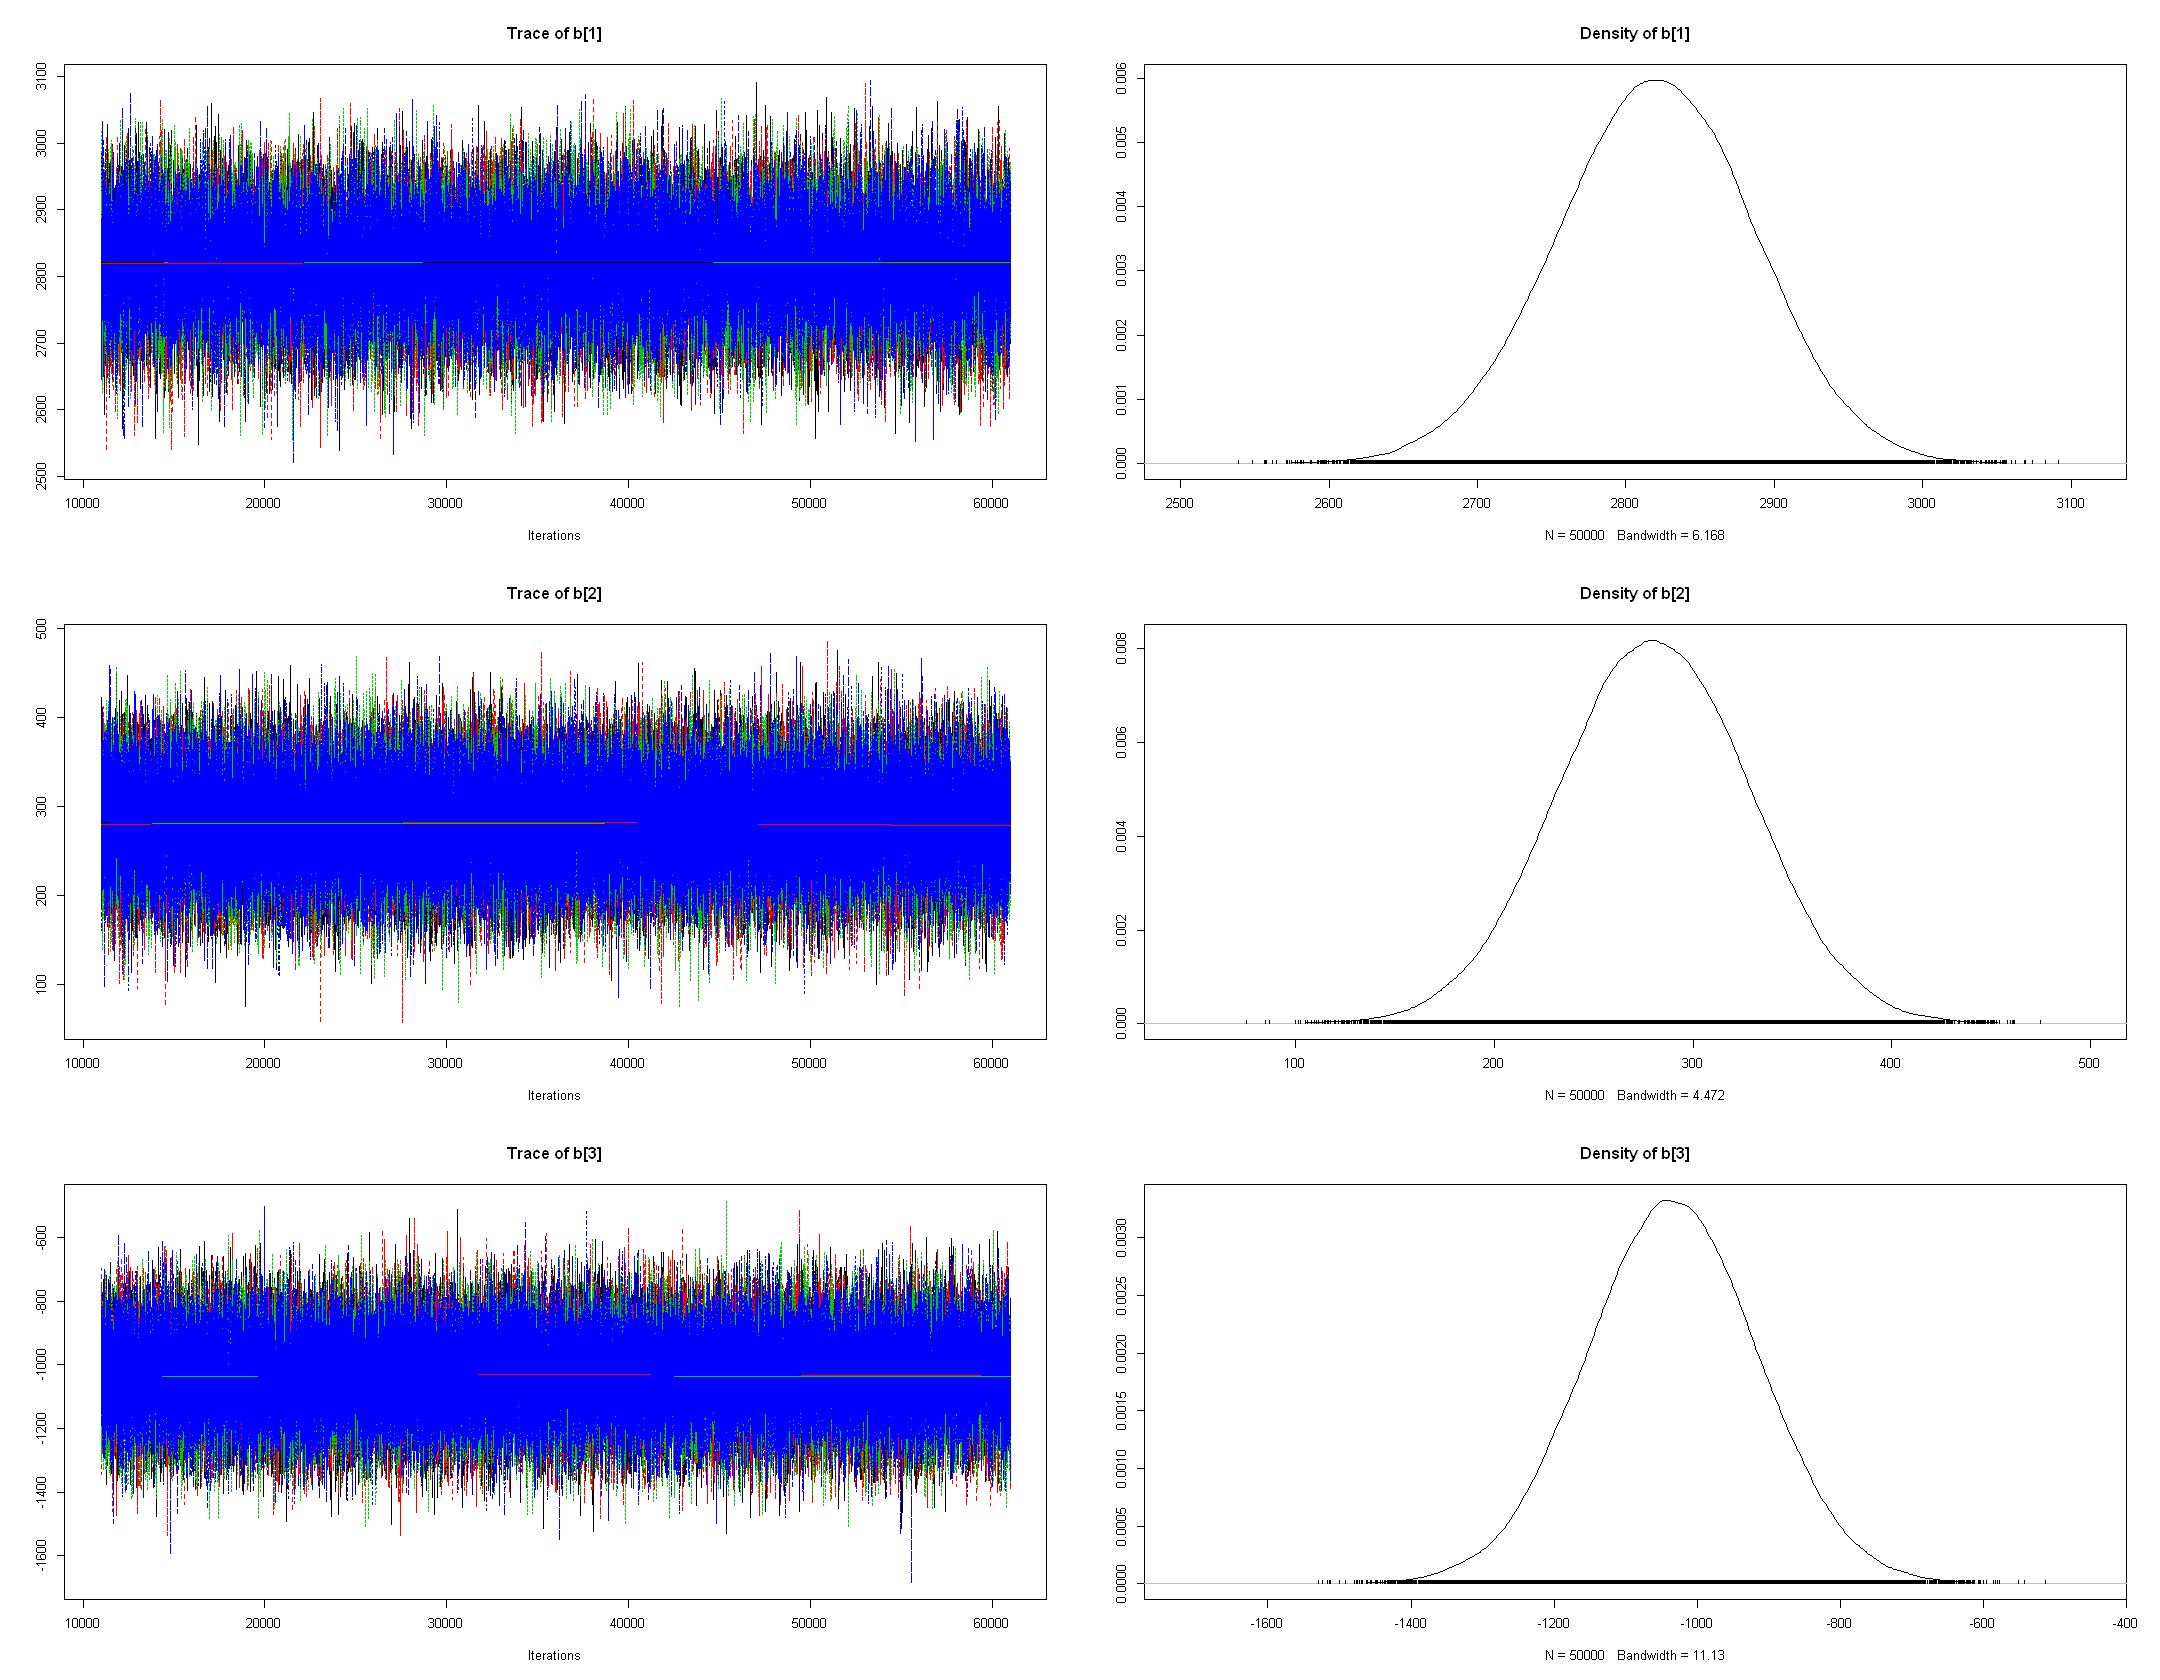

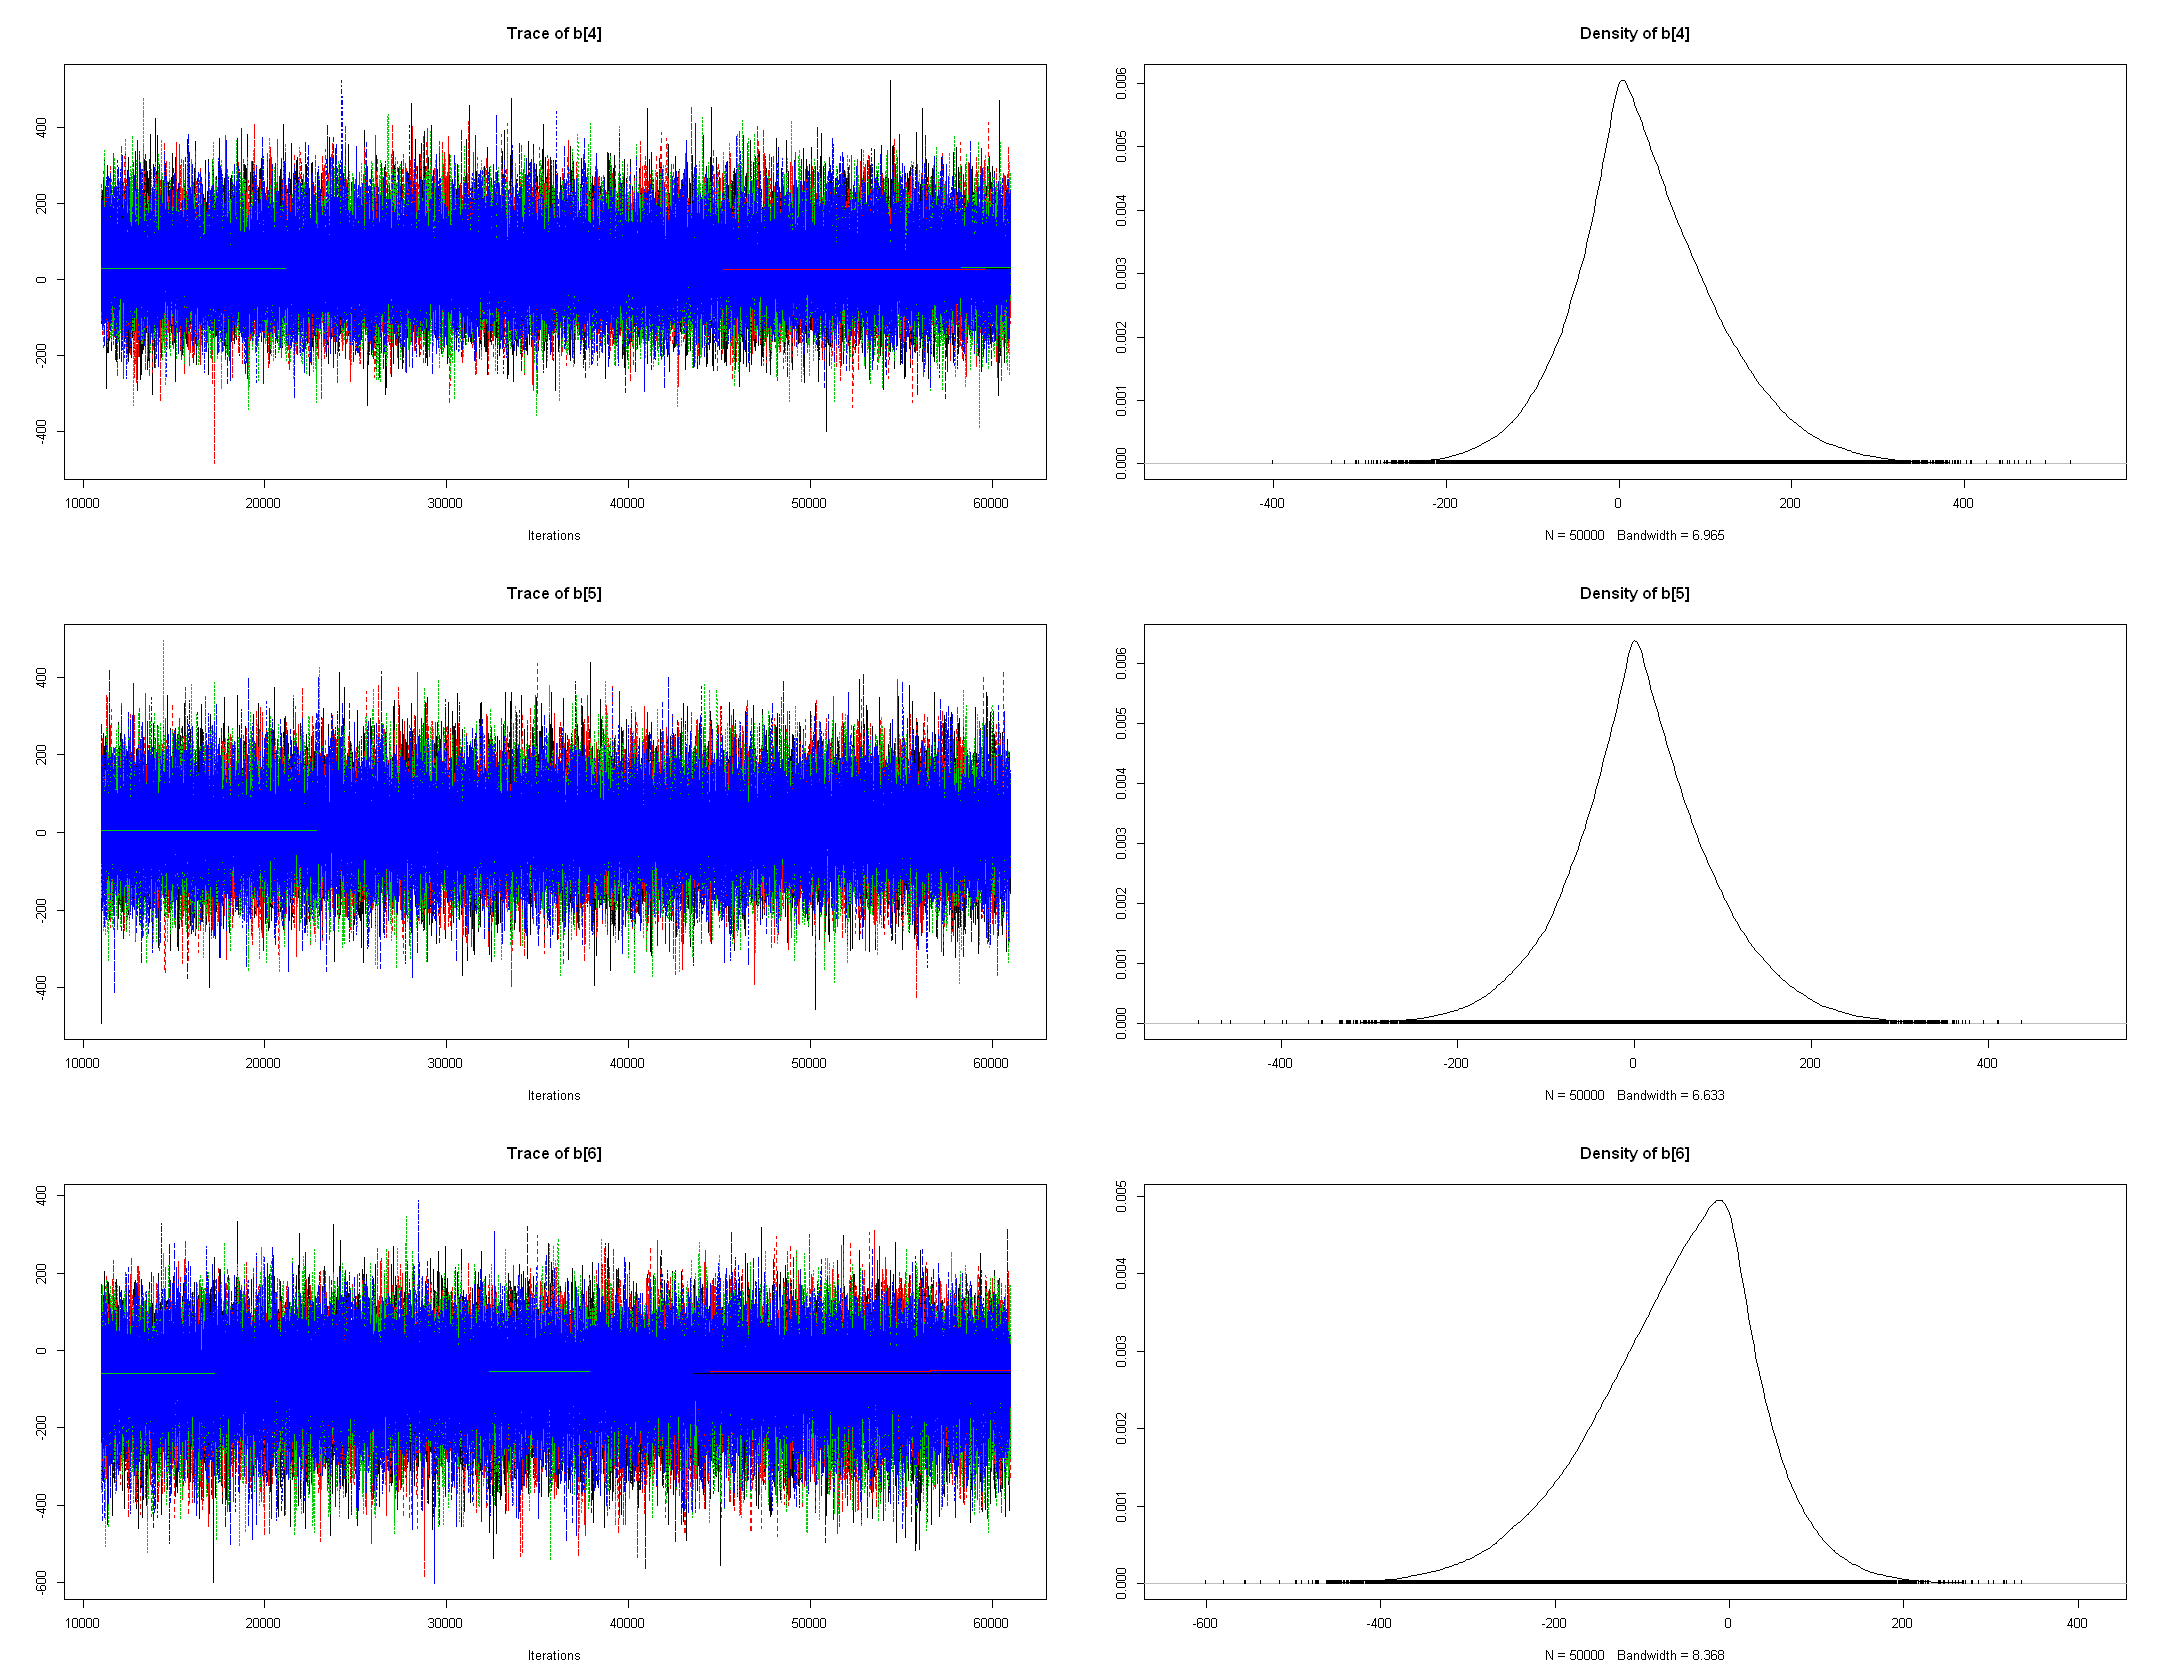

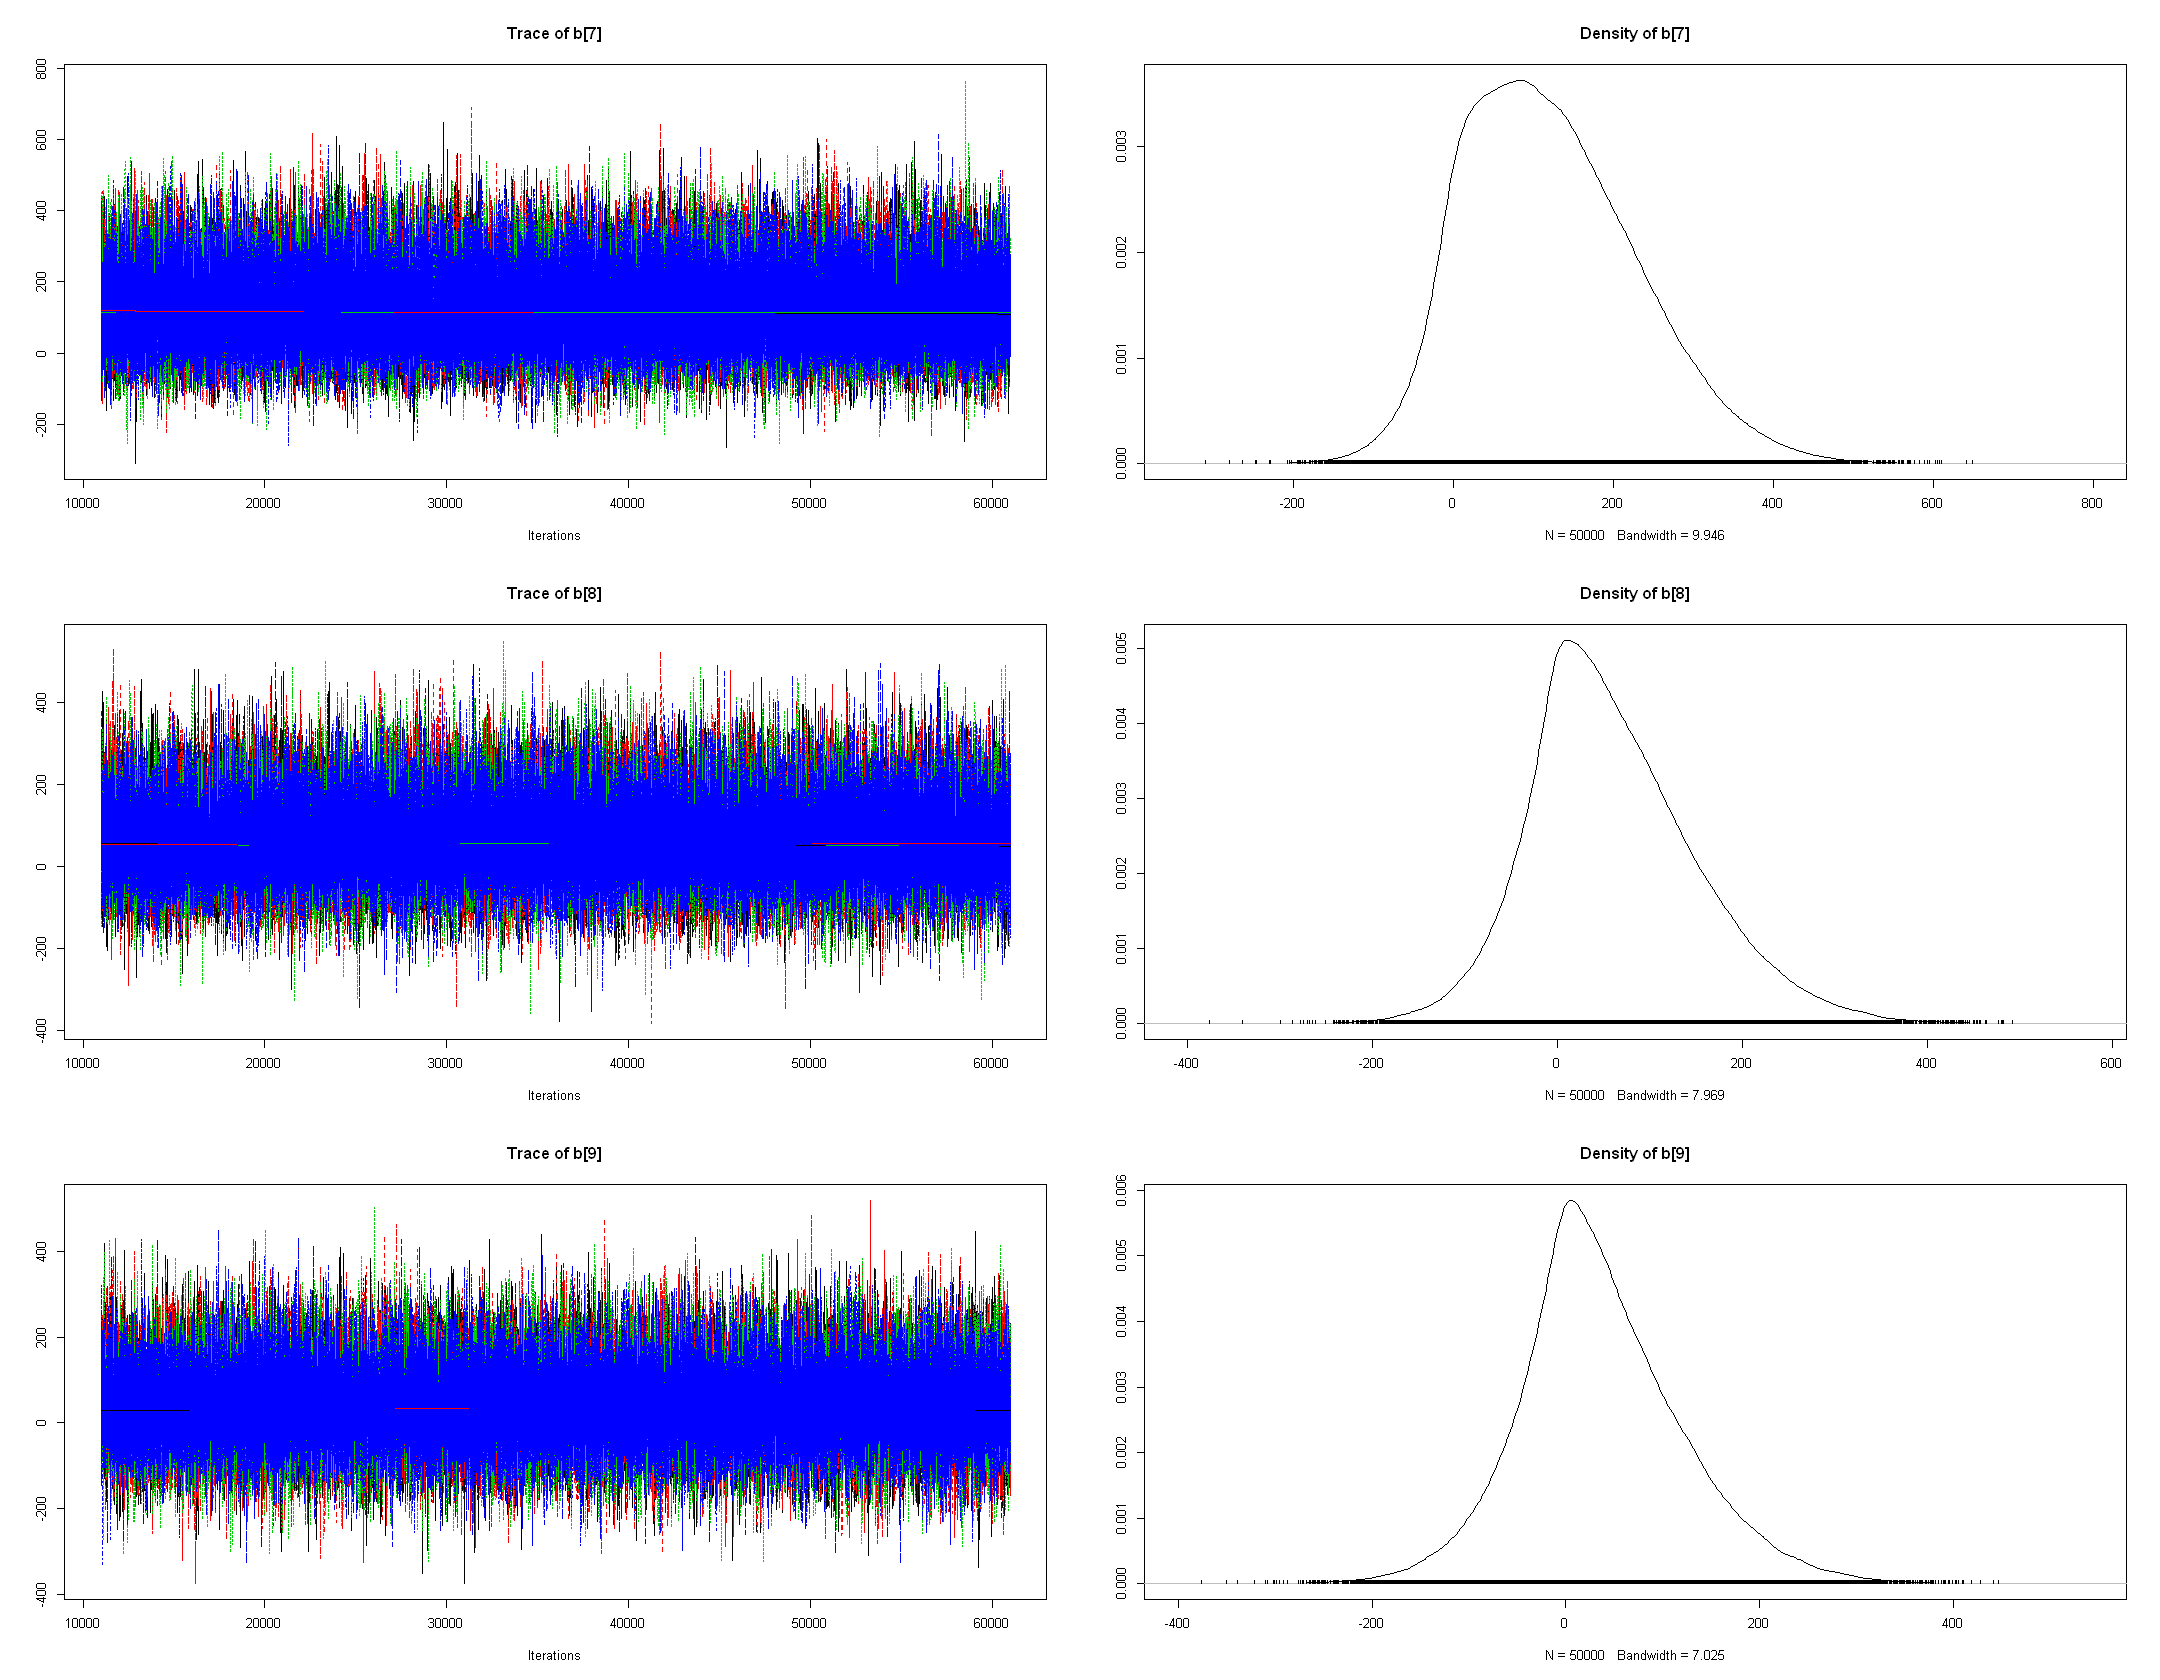

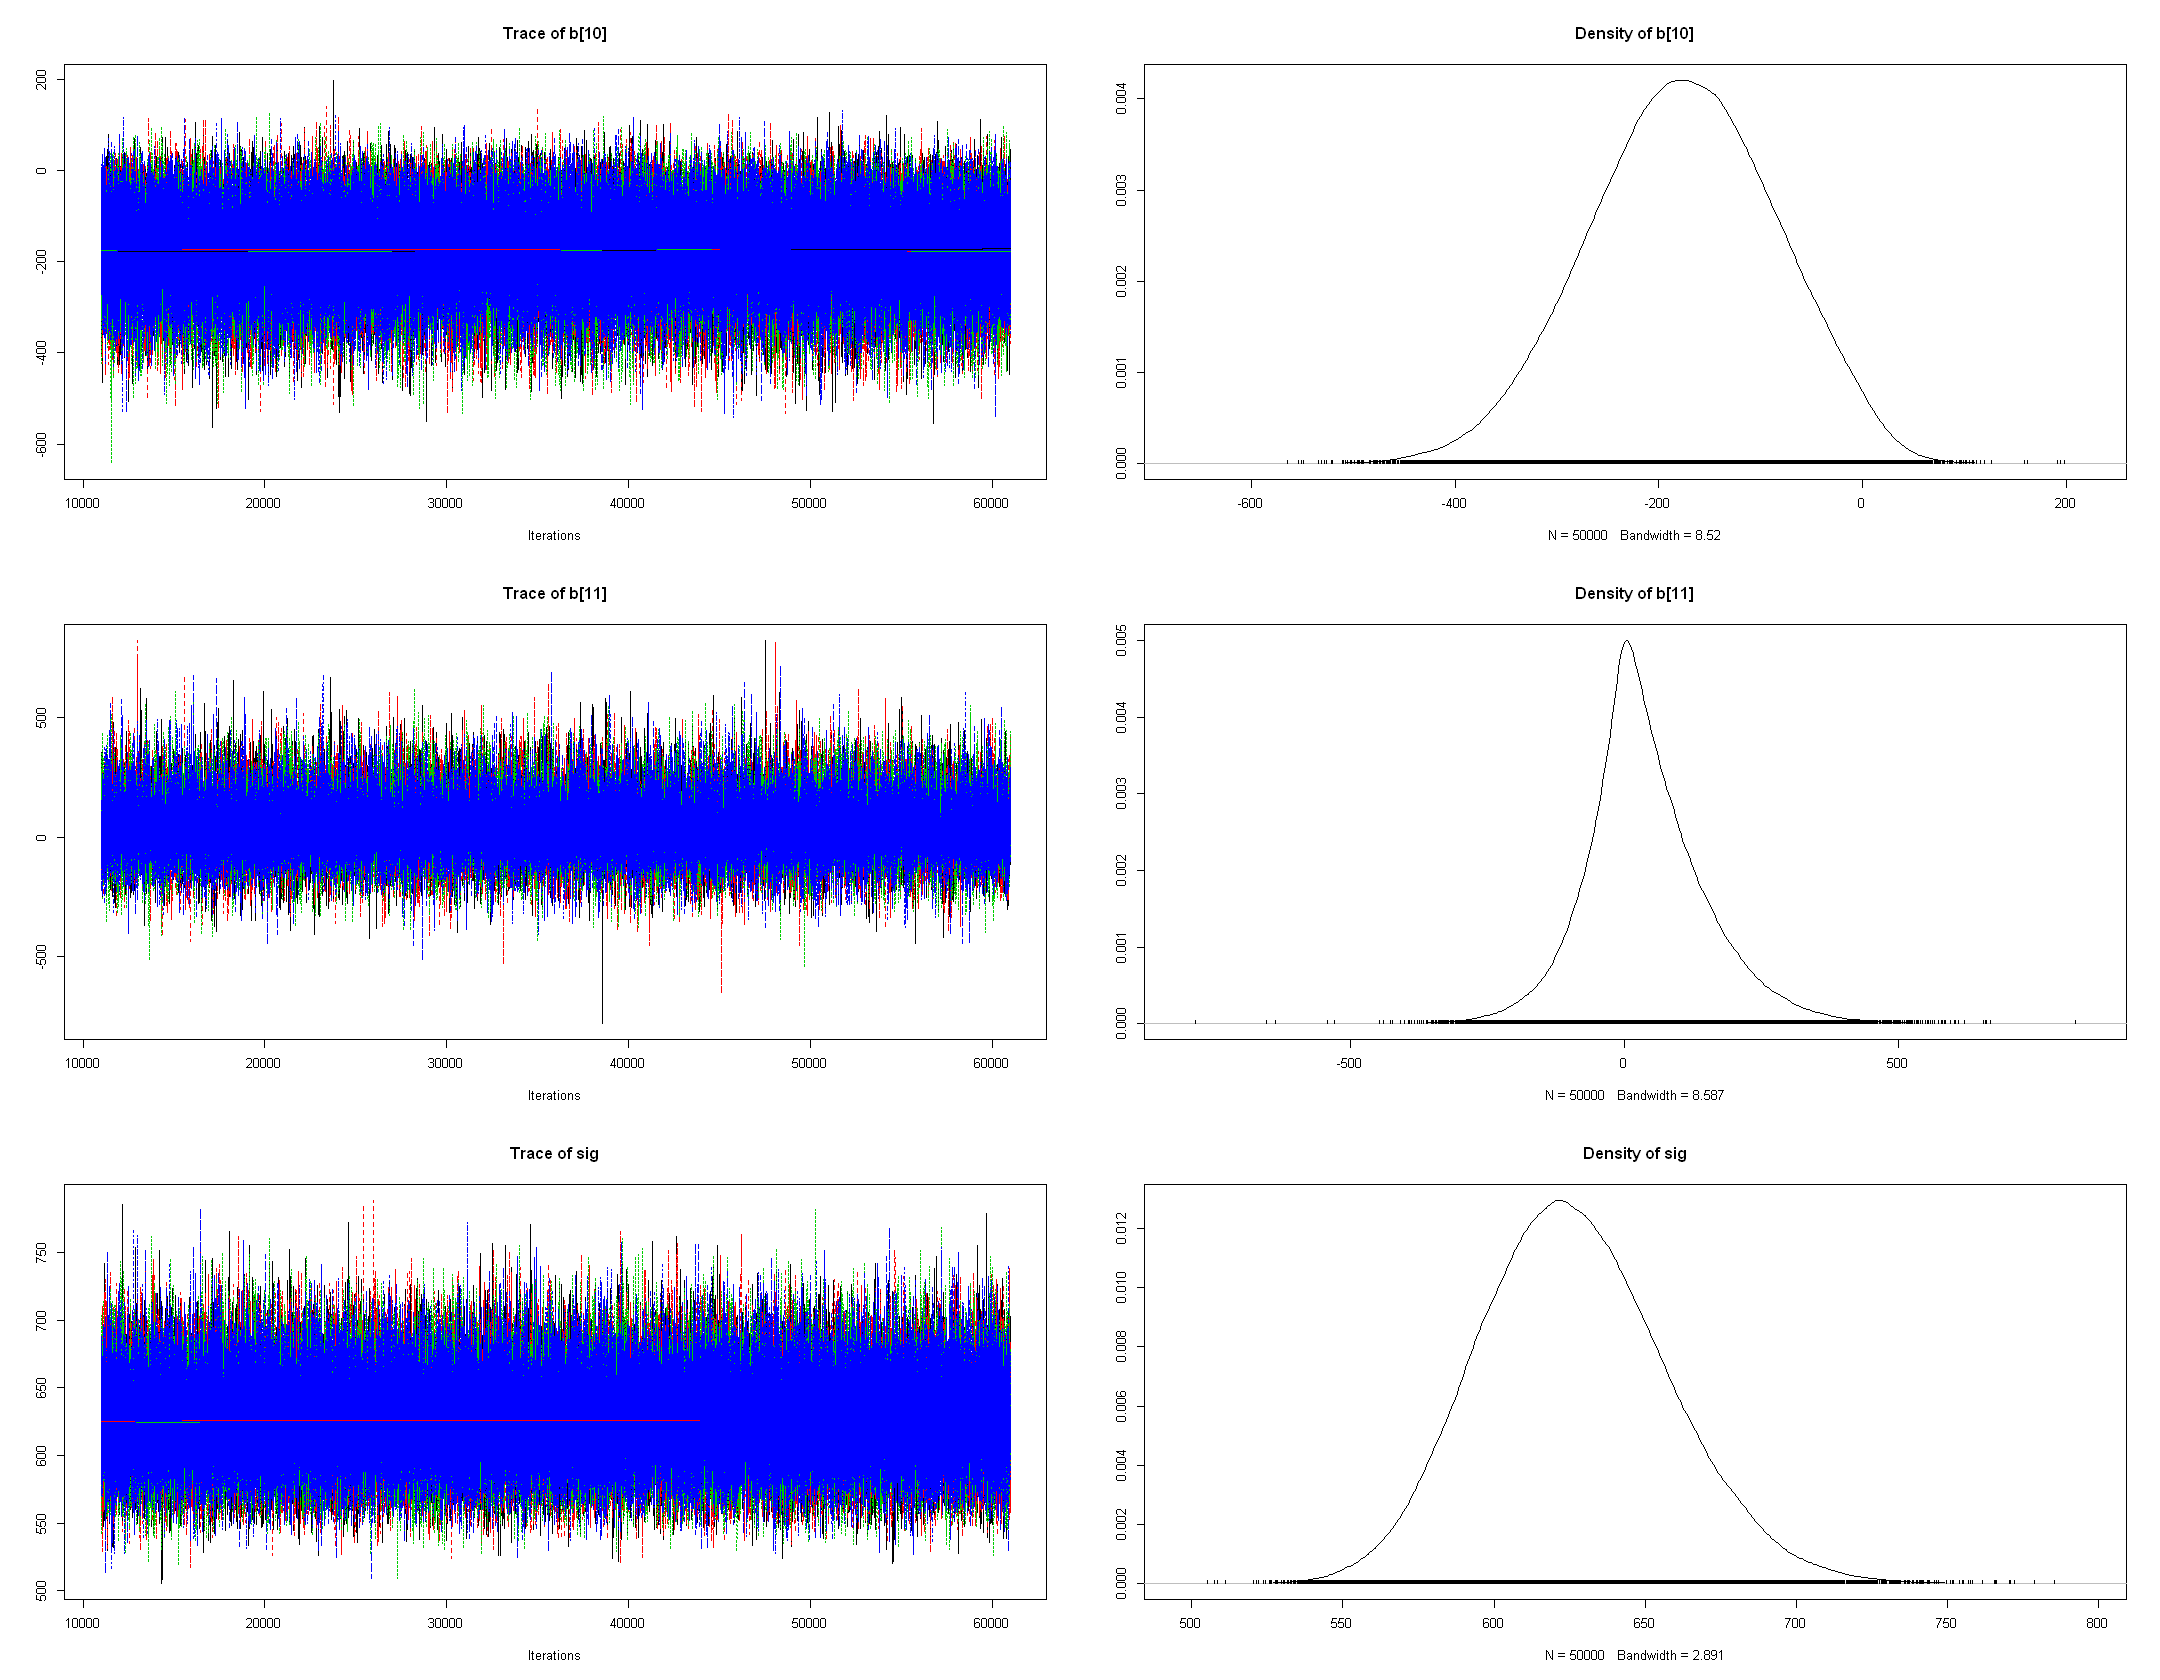

In [64]:
options(repr.plot.width=18, repr.plot.height=14)
plot(mod2_sim)

Chains seem to be wandering around a bit even after 50000 iterations. Also, the paramter estimates show alot of volatility showing that the way we have modeled our parameters is not correct. This was not the case with Poisson Regression doen above.

Let's look at Auto-correlations and Gelman Disgonostics.

In [65]:
gelman.diag(mod2_sim)

Potential scale reduction factors:

      Point est. Upper C.I.
b[1]           1          1
b[2]           1          1
b[3]           1          1
b[4]           1          1
b[5]           1          1
b[6]           1          1
b[7]           1          1
b[8]           1          1
b[9]           1          1
b[10]          1          1
b[11]          1          1
sig            1          1

Multivariate psrf

1

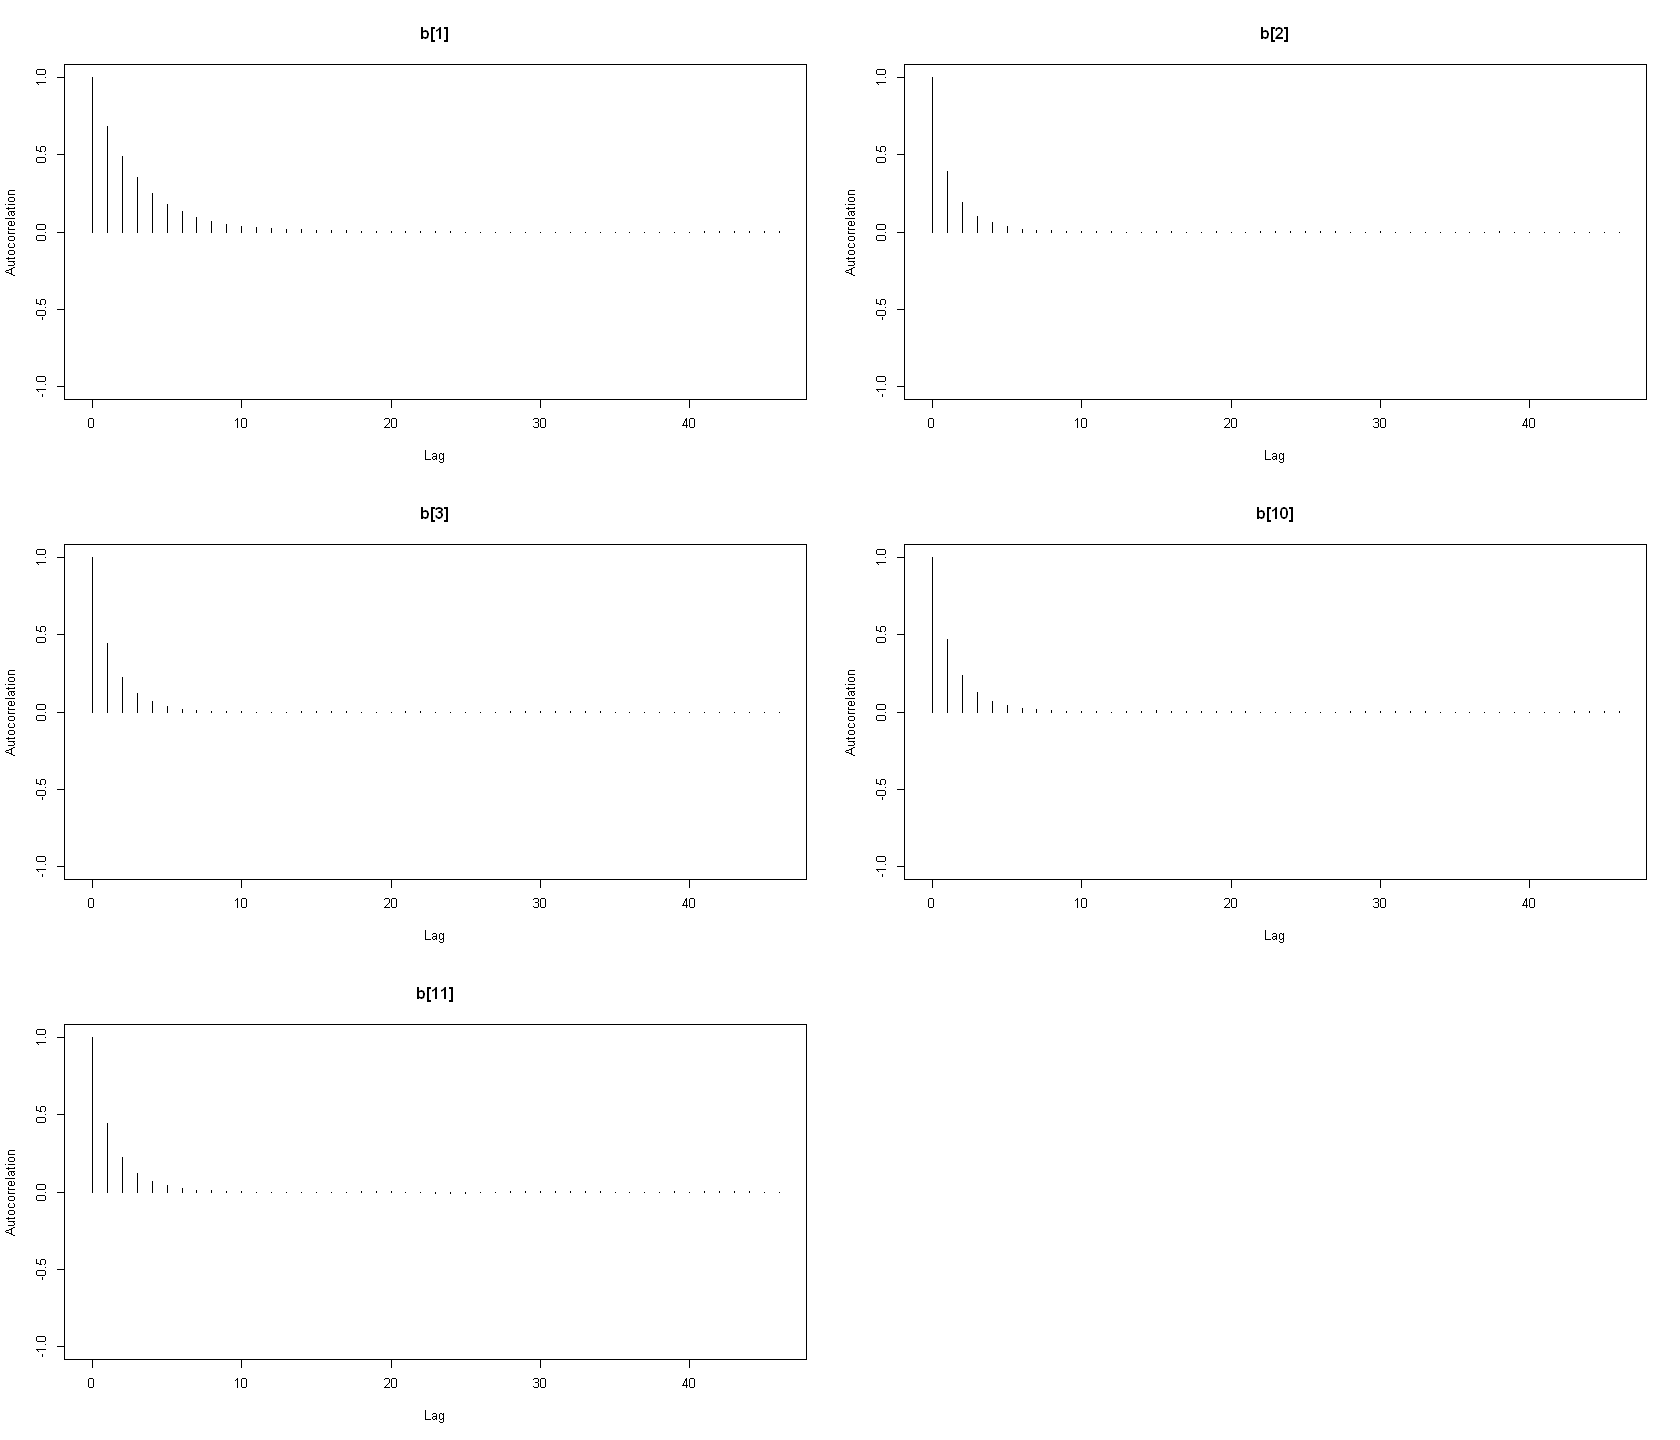

In [69]:
options(repr.plot.width=14, repr.plot.height=12)
autocorr.plot(mod2_csim[,c(1,2,3,10,11)])

The autocorrelation is fading out indicating iterations don't have much correlation which looks great, but then why do we have the volatility of estimates and large standard errors. The only reasonable explanation could be if our model is incorrect. Where we used Normal Likelihood to model the counts.

Comparison:
---

Let's check how the posterior distribution of the counts look like from 2 different models we used and the distribution of actual counts in the data.

In [79]:
params=colMeans(mod_csim)
params2=colMeans(mod2_csim)

params2=params2[1:11]
counts1_posterior=exp(params[1]+ X[,-1] %*% params[-1])
counts2_posterior=params2[1]+X[,-1] %*% params2[-1]

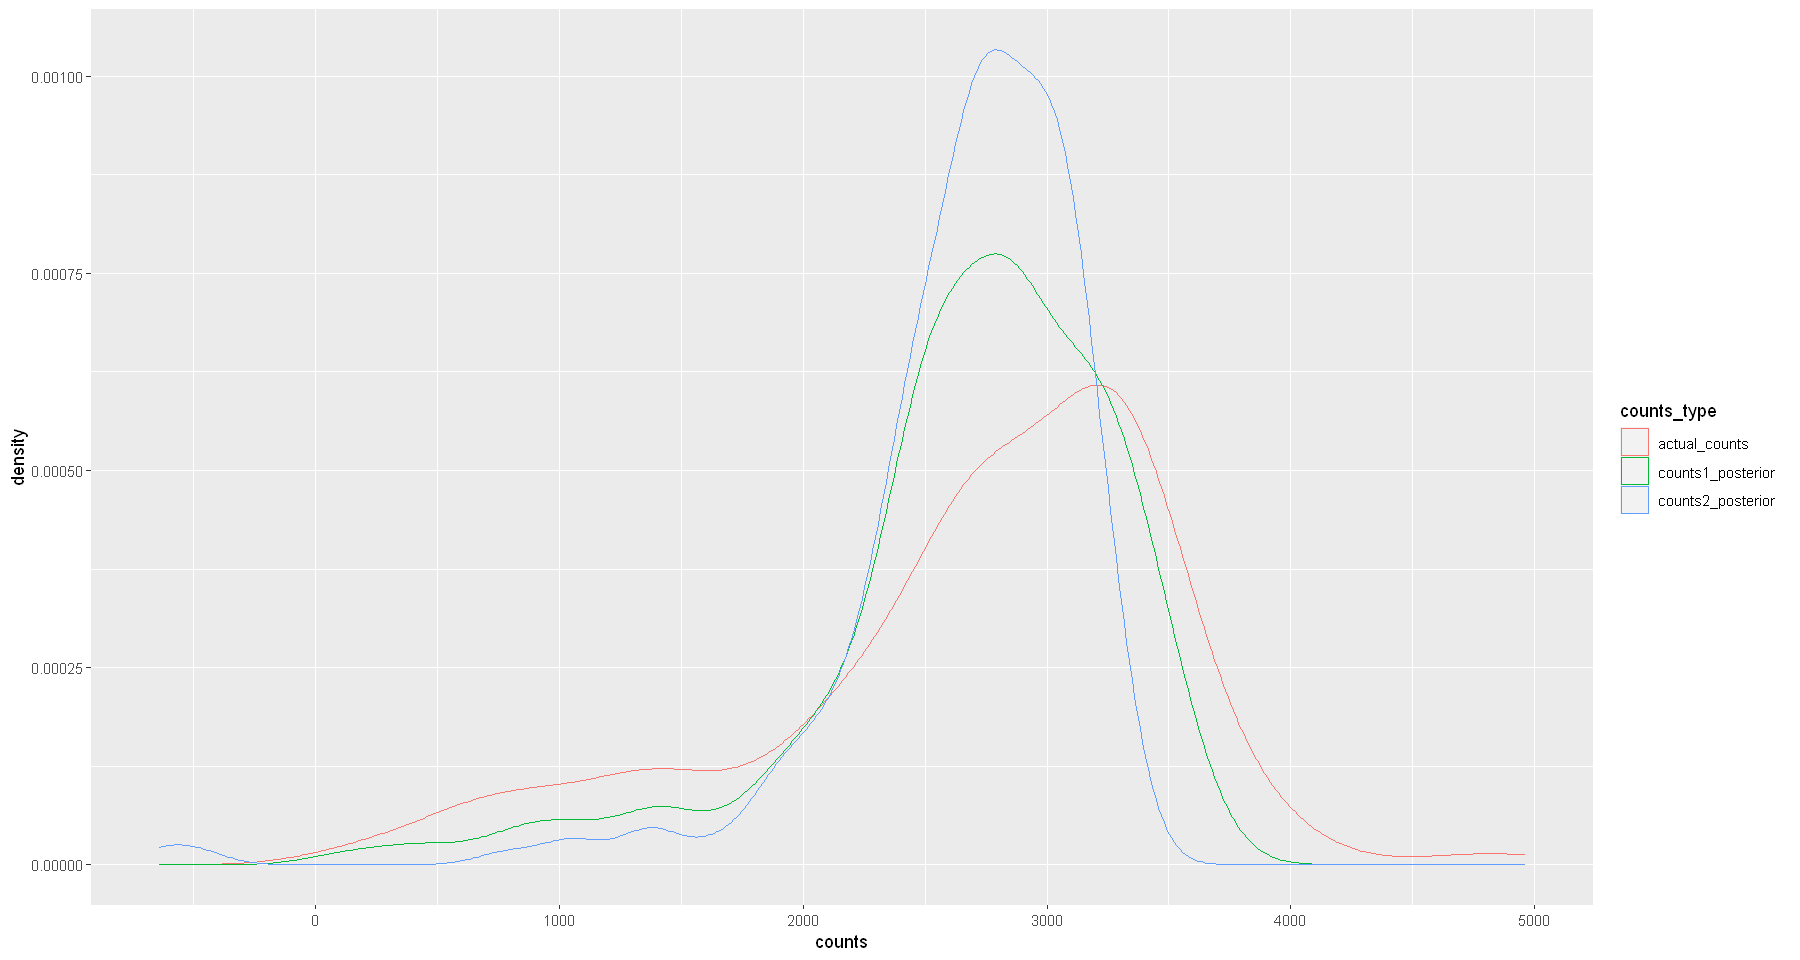

In [96]:
options(repr.plot.width=15, repr.plot.height=8)
actual=dataset$counts

datu_counts=data.frame(index=seq(1,length(actual),1),actual_counts=actual,counts1_posterior,counts2_posterior)
datu_counts=reshape2::melt(datu_counts,id="index",variable.name=c('counts_type'),value.name=c('counts'))
ggplot(datu_counts)+geom_density(aes(x=counts,col=counts_type))

Conclusion:
---

It seems like the Posterior distribution of the counts derived from the first model (Poisson Regression) has fatter tails and have tried to capture the actual distribution of the counts better than the one from 2nd model (Normal Linear Regression (Normal Liklihood)), which is more centered around the mean but have lighter tails and does'nt approximate the actual count distribution well. Thus, it seems like the Poisson Regression is better to model this count data.

This was my humble attempt to use Bayesian Modeling structure and use JAGS to implement the Poisson Regression with Lasso Implementation.

Why Bayesian:
---
Now the question that might arise would be that why would we want this whole mess of writing the code for JAGS and implementing regression and Lasso Regularization through Bayesian while we have pretty easy one line code to implement regression through MLE or OLS in Frequentist Paradigm. The answer is that in OLS or MLE estimation methods, you only get the point estimates for the paramters and get predictions for your response variable. And those are also point estimates for your response variable. What if someone ask us what is probability that your response variable would be smaller or greater than some value x. And that you can't tell without the Bayesian. So, Bayesian incorporates probablistic perspective in our way of quantifying uncertainty.

Let me give you an example from our data.

Let's look at the distribution of Counts of Bicycles during the month of June and February and want to know what is the probability that on weekdays the avg Counts of Bicycles in June is greater than the average counts of bicycles in September.   

In [65]:
# library(data.table)
dataset_model=data.table(dataset_model)

avg_temp_june=dataset_model[month=='6',.(avg_temp=mean(avg_temp),avg_precip=mean(precip))][[1]]
avg_precip_june=dataset_model[month=='6',.(avg_temp=mean(avg_temp),avg_precip=mean(precip))][[2]]

avg_temp_jul=dataset_model[month=='7',.(avg_temp=mean(avg_temp),avg_precip=mean(precip))][[1]]
avg_precip_jul=dataset_model[month=='7',.(avg_temp=mean(avg_temp),avg_precip=mean(precip))][[2]]

X_june=c(1,avg_temp_june,avg_precip_june,0,1,0,0,0,0,1,1*avg_precip_june)
X_jul=c(1,avg_temp_sep,avg_precip_sep,0,0,1,0,0,0,1,1*avg_precip_jul)


In [66]:
lam_june=exp(X_june[1]+mod_csim[,-1] %*% X_june[-1])
lam_jul=exp(X_jul[1]+mod_csim[,-1] %*% X_jul[-1])

In [67]:
june_dist=rpois(15000,lam_june)
jul_dist=rpois(15000,lam_jul)

In [68]:
prob=mean(june_dist>jul_dist)

In [69]:
prob

[1] 0.3947333

So, there is 39.47% probability that on weekdays in June the Counts of Bicycles would be greater than those in July.
This is something that Bayesian Approach to modeling can help us achieve.